In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local

sidm_path = str(os.getcwd()).split("/sidm")[0]
# sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, cutflow
from sidm.tools import llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm
import coffea.util
import numpy as np

In [2]:
samples = [
    "2Mu2E_200GeV_5p0GeV_0p2mm",
    "2Mu2E_200GeV_5p0GeV_200p0mm",
    "2Mu2E_1000GeV_0p25GeV_0p002mm",
    "2Mu2E_1000GeV_0p25GeV_2p0mm",
]

In [12]:
fileset = utilities.make_fileset(samples[0:4], 
                                 "llpNanoAOD_v2", 
                                 location_cfg="signal_2mu2e_v10.yaml",
                                 max_files = 10,
                                )

In [3]:
runner = processor.Runner(
    # executor=processor.DaskExecutor(client=client),
    executor=processor.IterativeExecutor(),
    schema=llpnanoaodschema.LLPNanoAODSchema,
    skipbadfiles=True
)
#    maxchunks=10, 

channels = [
    "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR_cut", "baseNoLj_DP_matching_seg_veto", "baseNoLj_DP_matching_seg_veto_charge",
    "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_all",
]

p = sidm_processor.SidmProcessor(
    channels,
    ["muon_crosscleaning_base"],
    unweighted_hist=True,
)

# out = {}
# for i, sample in enumerate(samples):

#     print(f"Processing {sample}")
#     fileset_one_sample = {samples[i]:fileset.get(samples[i])}
    
#     output = runner.run(fileset_one_sample, treename='Events', processor_instance=p)

#     #Add this sample's output to the out variable
#     out[sample] = output["out"][sample]

#     ##Save output to a file!!
#     out_file_name = "output_" + sample + ".coffea"
#     coffea.util.save(output,out_file_name)

In [4]:
#First check if there is already an out dictionary
try:
    out
    print("The _out_ dictionary already exists; will use what is saved in memory if possible")
except NameError:
    print("WARNING! No processor output stored in the kernel's memory. Will try to load pickled coffea file for each sample instead")
    out = {}

#For each sample, try to use the data in memory if possible; if not try to load the file
#If those both fail, then raise an error and skip it
for sample in samples:
    if sample in out:
        print(f"{sample} already found in memory; not loading file")
    else:
        print(f"Loading file for sample {sample}")
        filename = "output_" + sample + ".coffea"
        try: 
            output = coffea.util.load(filename)
            print("Successfully opened file")        
            out[sample] = output["out"][sample]
        except FileNotFoundError:
            print("**** ERROR! File not found. Check the file name, or run the processor again and save the output to a pickle file using coffea.util.save")

WARNING! No processor output stored in the kernel's memory. Will try to load pickled coffea file for each sample instead
Loading file for sample 2Mu2E_200GeV_5p0GeV_0p2mm
Successfully opened file
Loading file for sample 2Mu2E_200GeV_5p0GeV_200p0mm
Successfully opened file
Loading file for sample 2Mu2E_1000GeV_0p25GeV_0p002mm
Successfully opened file
Loading file for sample 2Mu2E_1000GeV_0p25GeV_2p0mm
Successfully opened file


In [5]:
histnames = [
    "genAs_toMu_lxy_nosel", "genAs_toMu_lxy_noDSA", "genAs_toMu_lxy_oneDSA", "genAs_toMu_lxy_twoDSA",
    "genAs_toMu_lxy_noPF", "genAs_toMu_lxy_noPF_noDSA", "genAs_toMu_lxy_noPF_oneDSA", "genAs_toMu_lxy_noPF_twoDSA",
    "genAs_toMu_lxy_onePF", "genAs_toMu_lxy_onePF_noDSA", "genAs_toMu_lxy_onePF_oneDSA", "genAs_toMu_lxy_onePF_twoDSA",
    "genAs_toMu_lxy_twoPF", "genAs_toMu_lxy_twoPF_noDSA", "genAs_toMu_lxy_twoPF_oneDSA", "genAs_toMu_lxy_twoPF_twoDSA"
]

histnames_large = [
    "genAs_toMu_lxy_nosel_large", "genAs_toMu_lxy_noDSA_large", "genAs_toMu_lxy_oneDSA_large", "genAs_toMu_lxy_twoDSA_large",
    "genAs_toMu_lxy_noPF_large", "genAs_toMu_lxy_noPF_noDSA_large", "genAs_toMu_lxy_noPF_oneDSA_large", "genAs_toMu_lxy_noPF_twoDSA_large",
    "genAs_toMu_lxy_onePF_large", "genAs_toMu_lxy_onePF_noDSA_large", "genAs_toMu_lxy_onePF_oneDSA_large", "genAs_toMu_lxy_onePF_twoDSA_large",
    "genAs_toMu_lxy_twoPF_large", "genAs_toMu_lxy_twoPF_noDSA_large", "genAs_toMu_lxy_twoPF_oneDSA_large", "genAs_toMu_lxy_twoPF_twoDSA_large"
]

histtitle= ["PF=nosel, DSA=nosel", "PF=nosel, DSA=0", "PF=nosel, DSA=1", "PF=nosel, DSA=2",
            "PF=0, DSA=nosel", "PF=0, DSA=0", "PF=0, DSA=1", "PF=0, DSA=2",
            "PF=1, DSA=nosel", "PF=1, DSA=0", "PF=1, DSA=1", "PF=1, DSA=2",
            "PF=2, DSA=nosel", "PF=2, DSA=0", "PF=2, DSA=1", "PF=2, DSA=2",
           ]

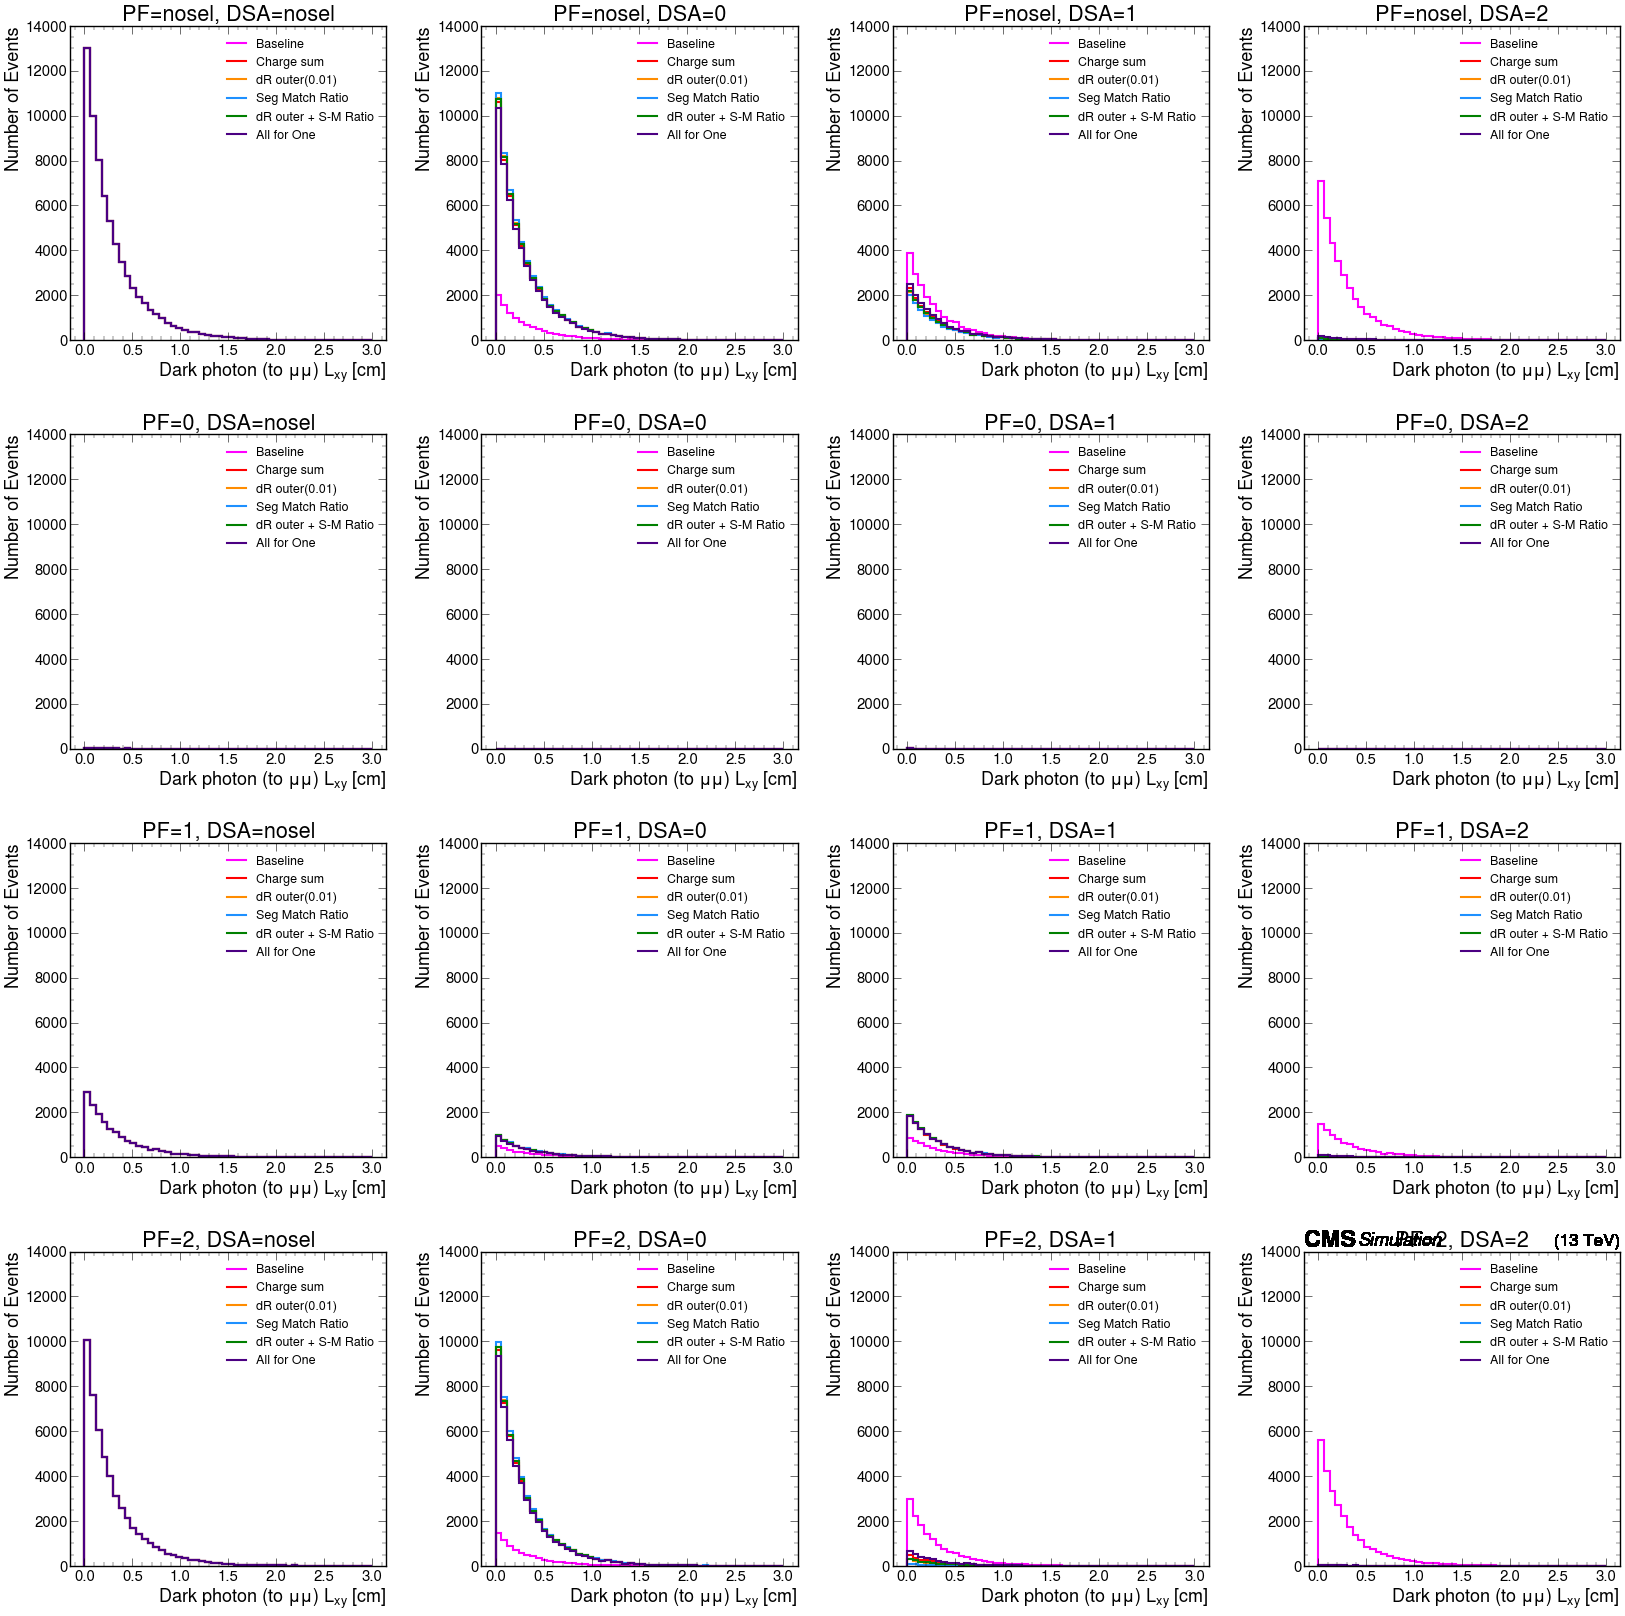

In [15]:
sample = "2Mu2E_1000GeV_0p25GeV_0p002mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 14000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

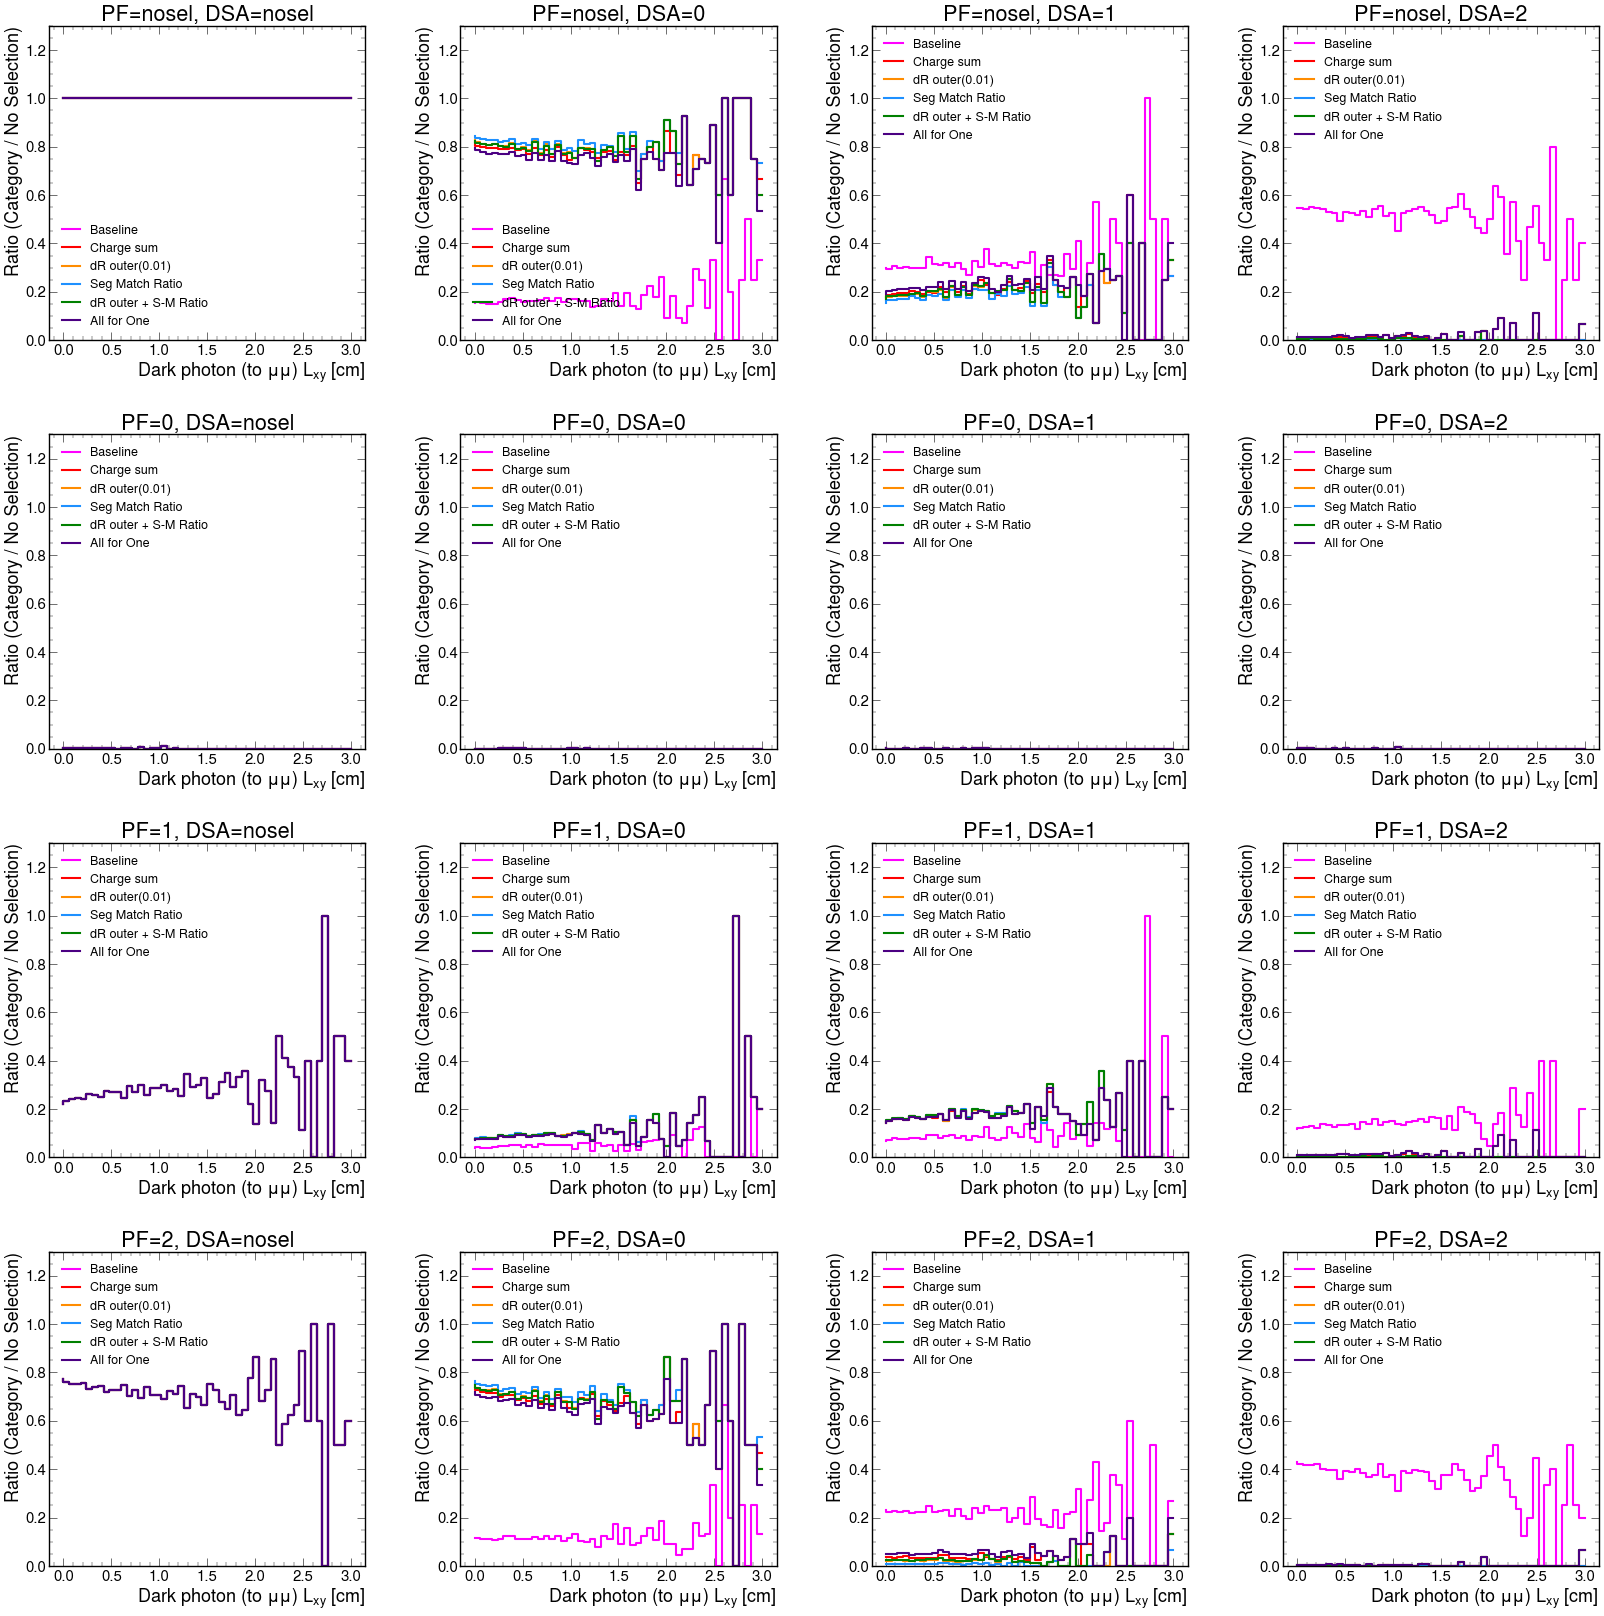

In [18]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_DP_matching", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_DP_matching", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_ylim(0, 1.3)
            ax.set_title(histtitle[i])
            ax.set_xlabel(r"Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i in [0,1]:
        ax.legend(loc='lower left', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


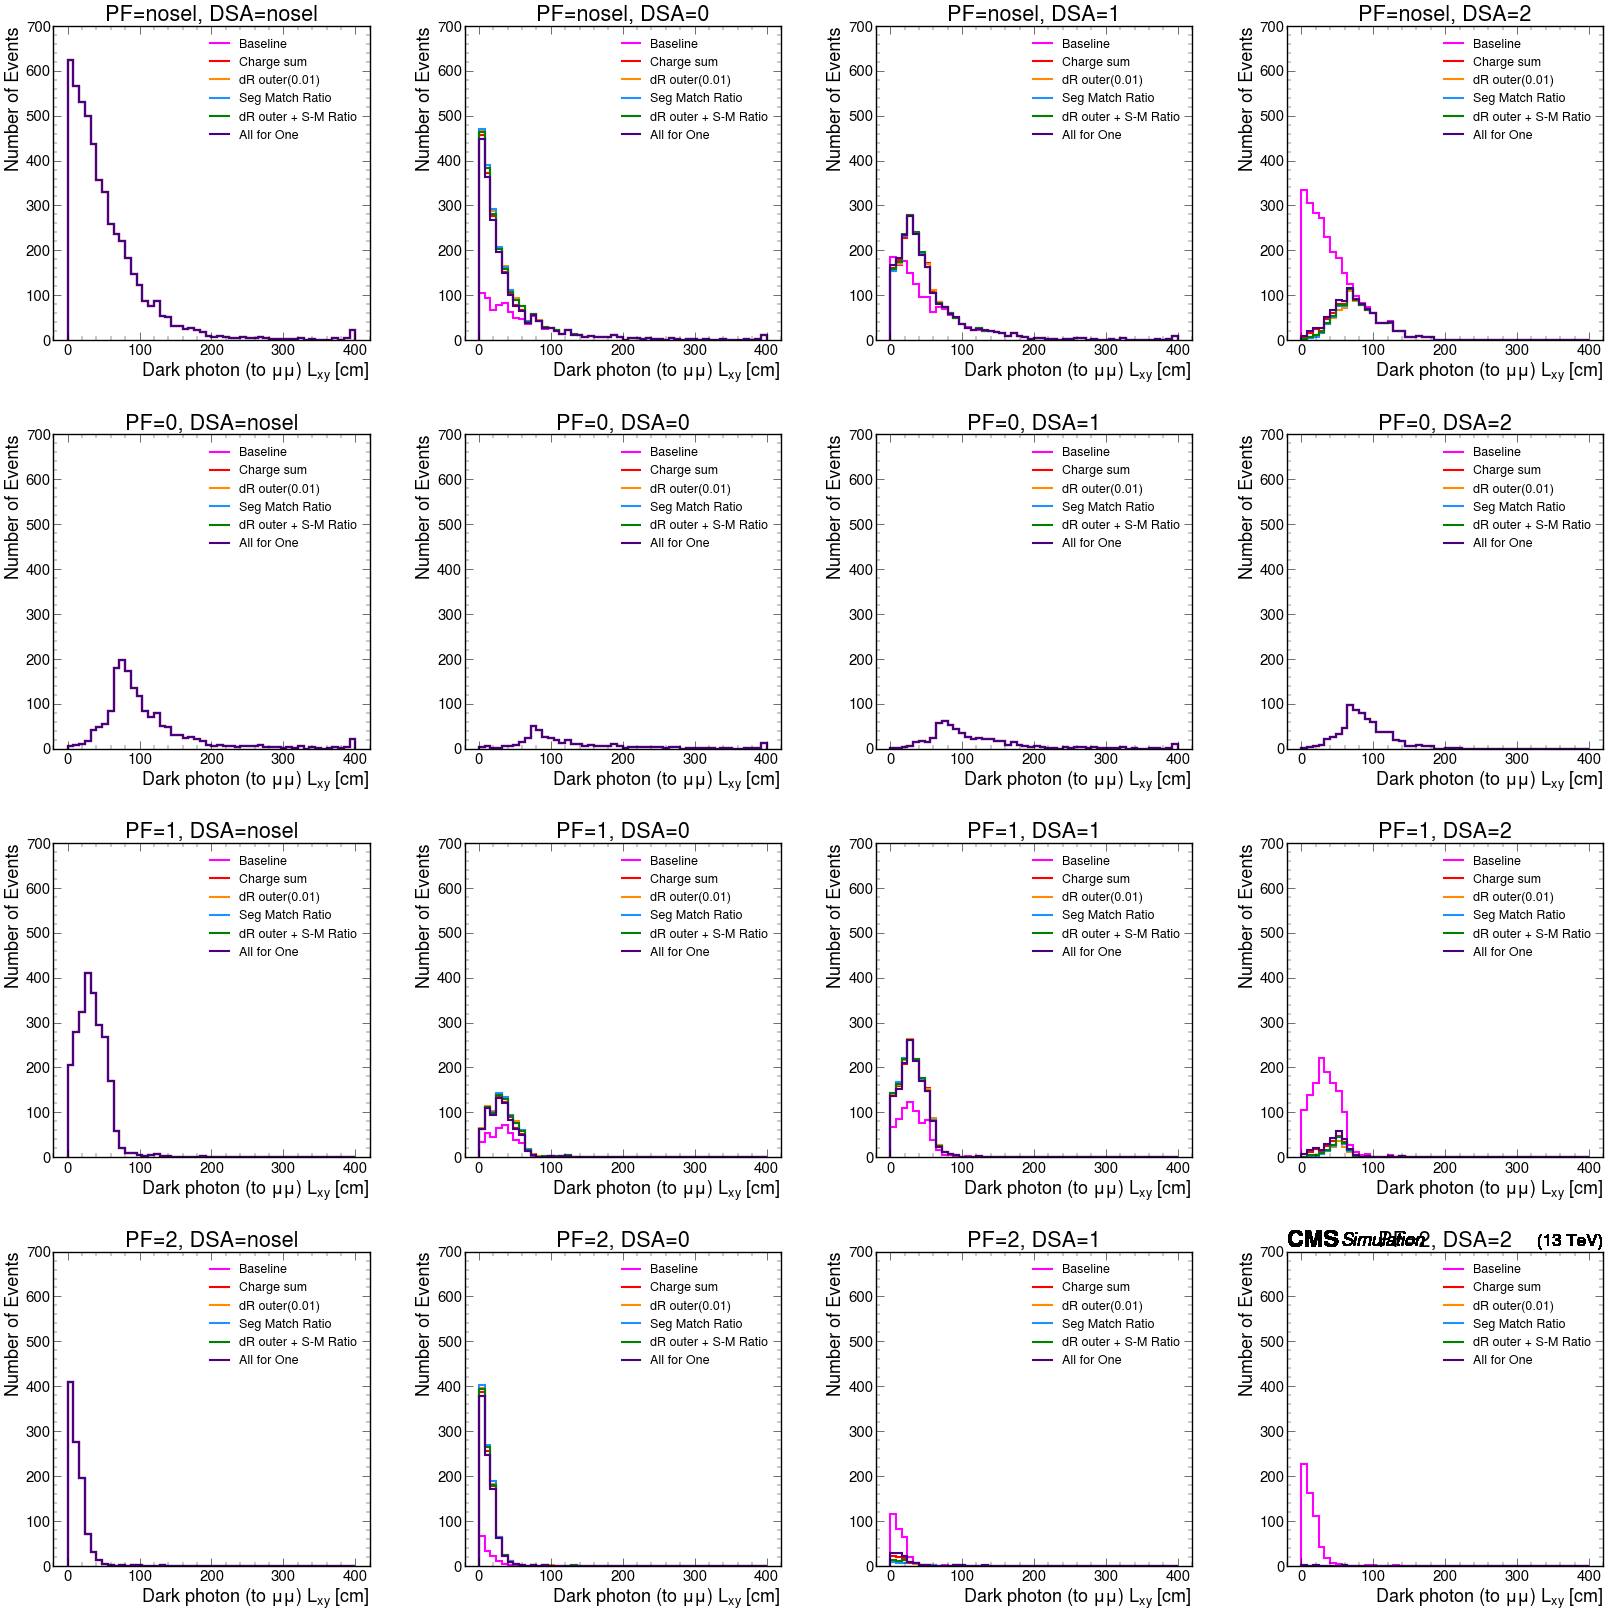

In [19]:
sample = "2Mu2E_1000GeV_0p25GeV_2p0mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 700)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

/tmp/ipykernel_12043/1108875029.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_vals = numerator / denominator


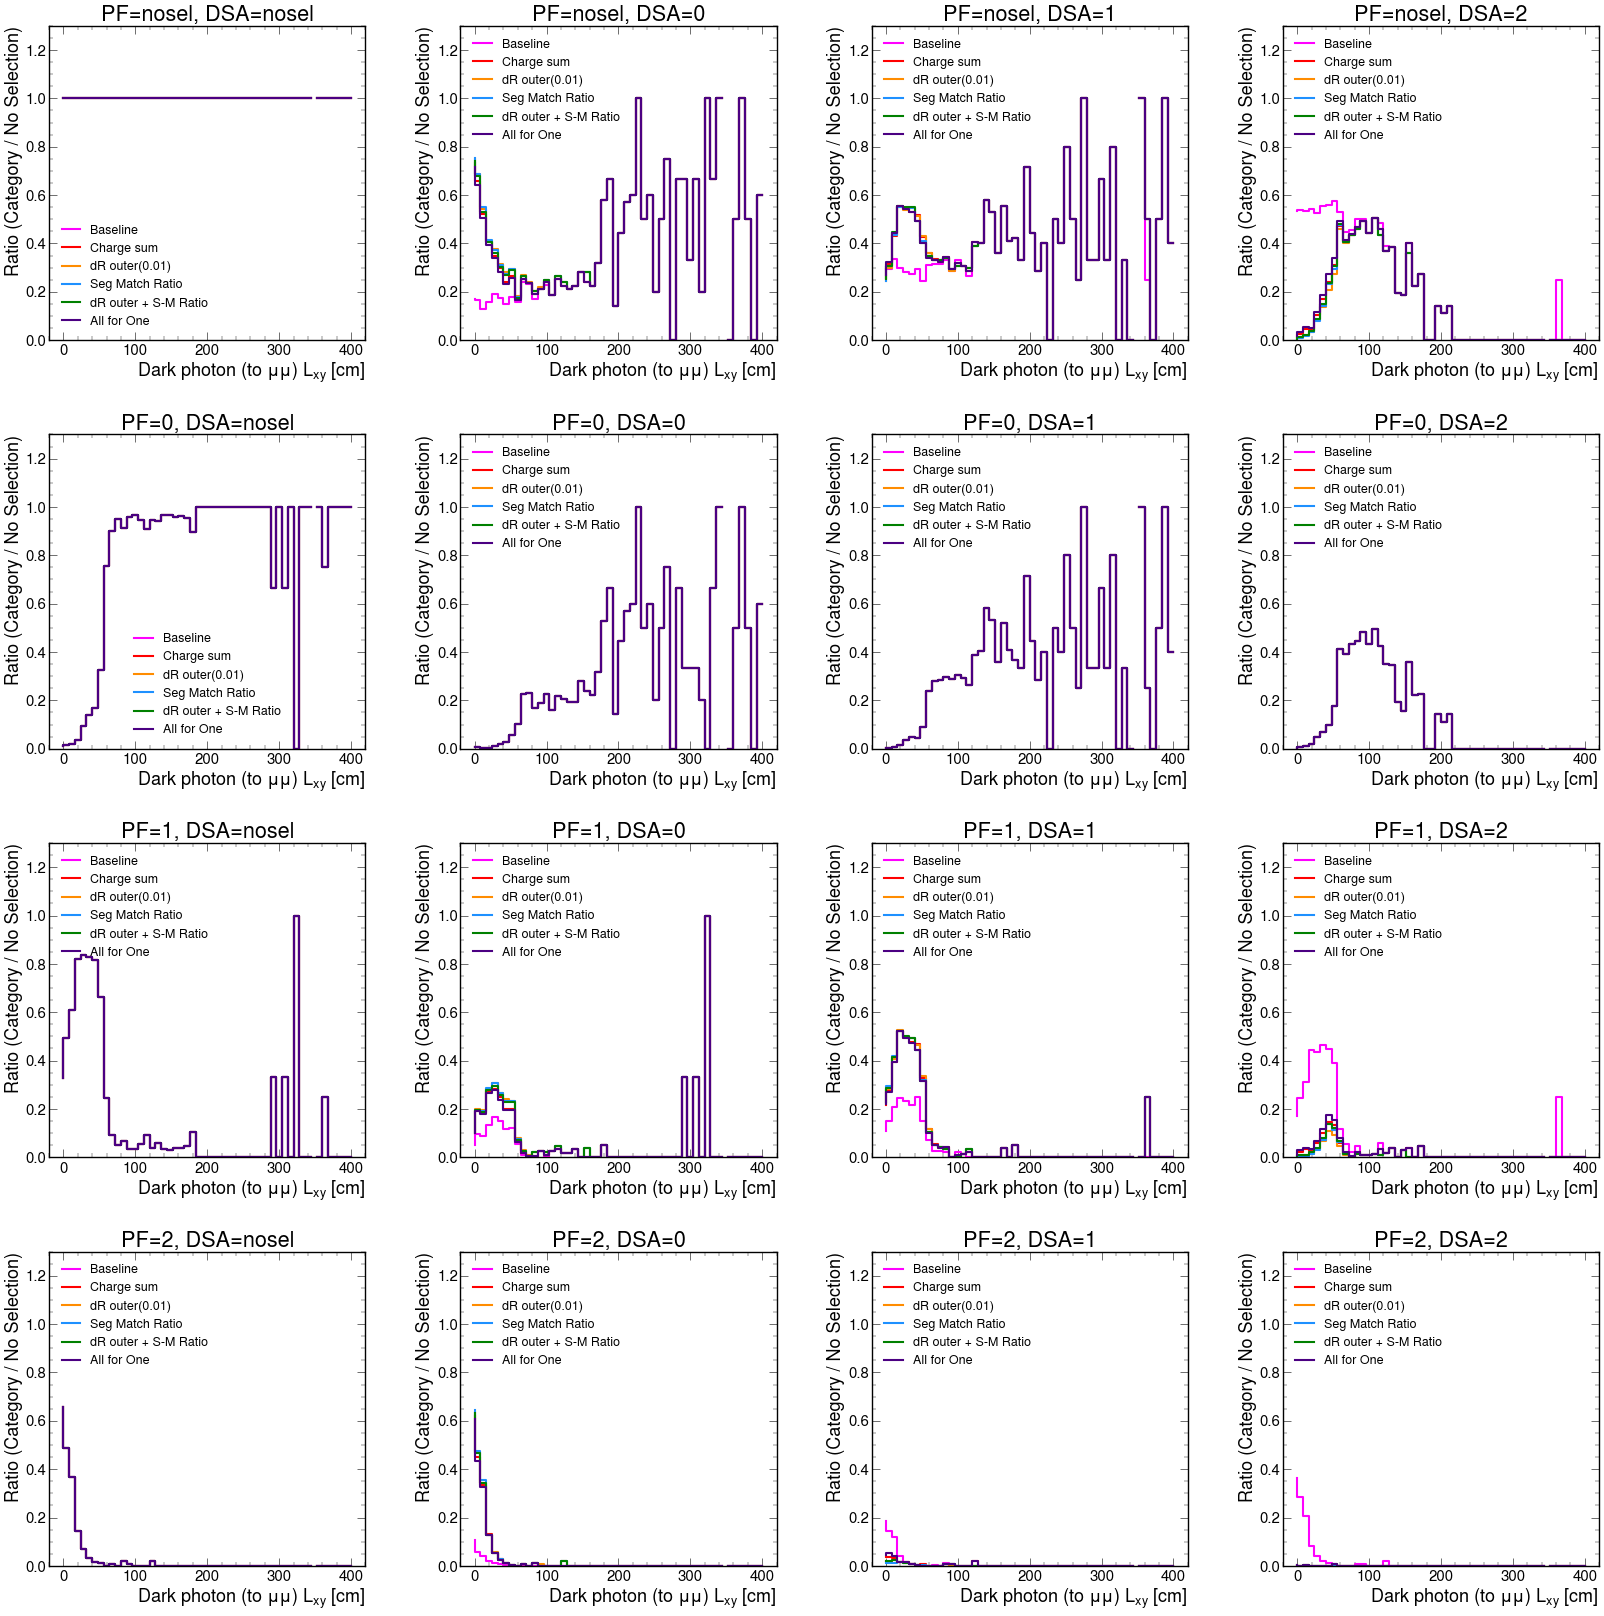

In [22]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_DP_matching", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_DP_matching", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_ylim(0, 1.3)
            ax.set_title(histtitle[i])
            ax.set_xlabel(r"Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 4:
        ax.legend(loc='lower center', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


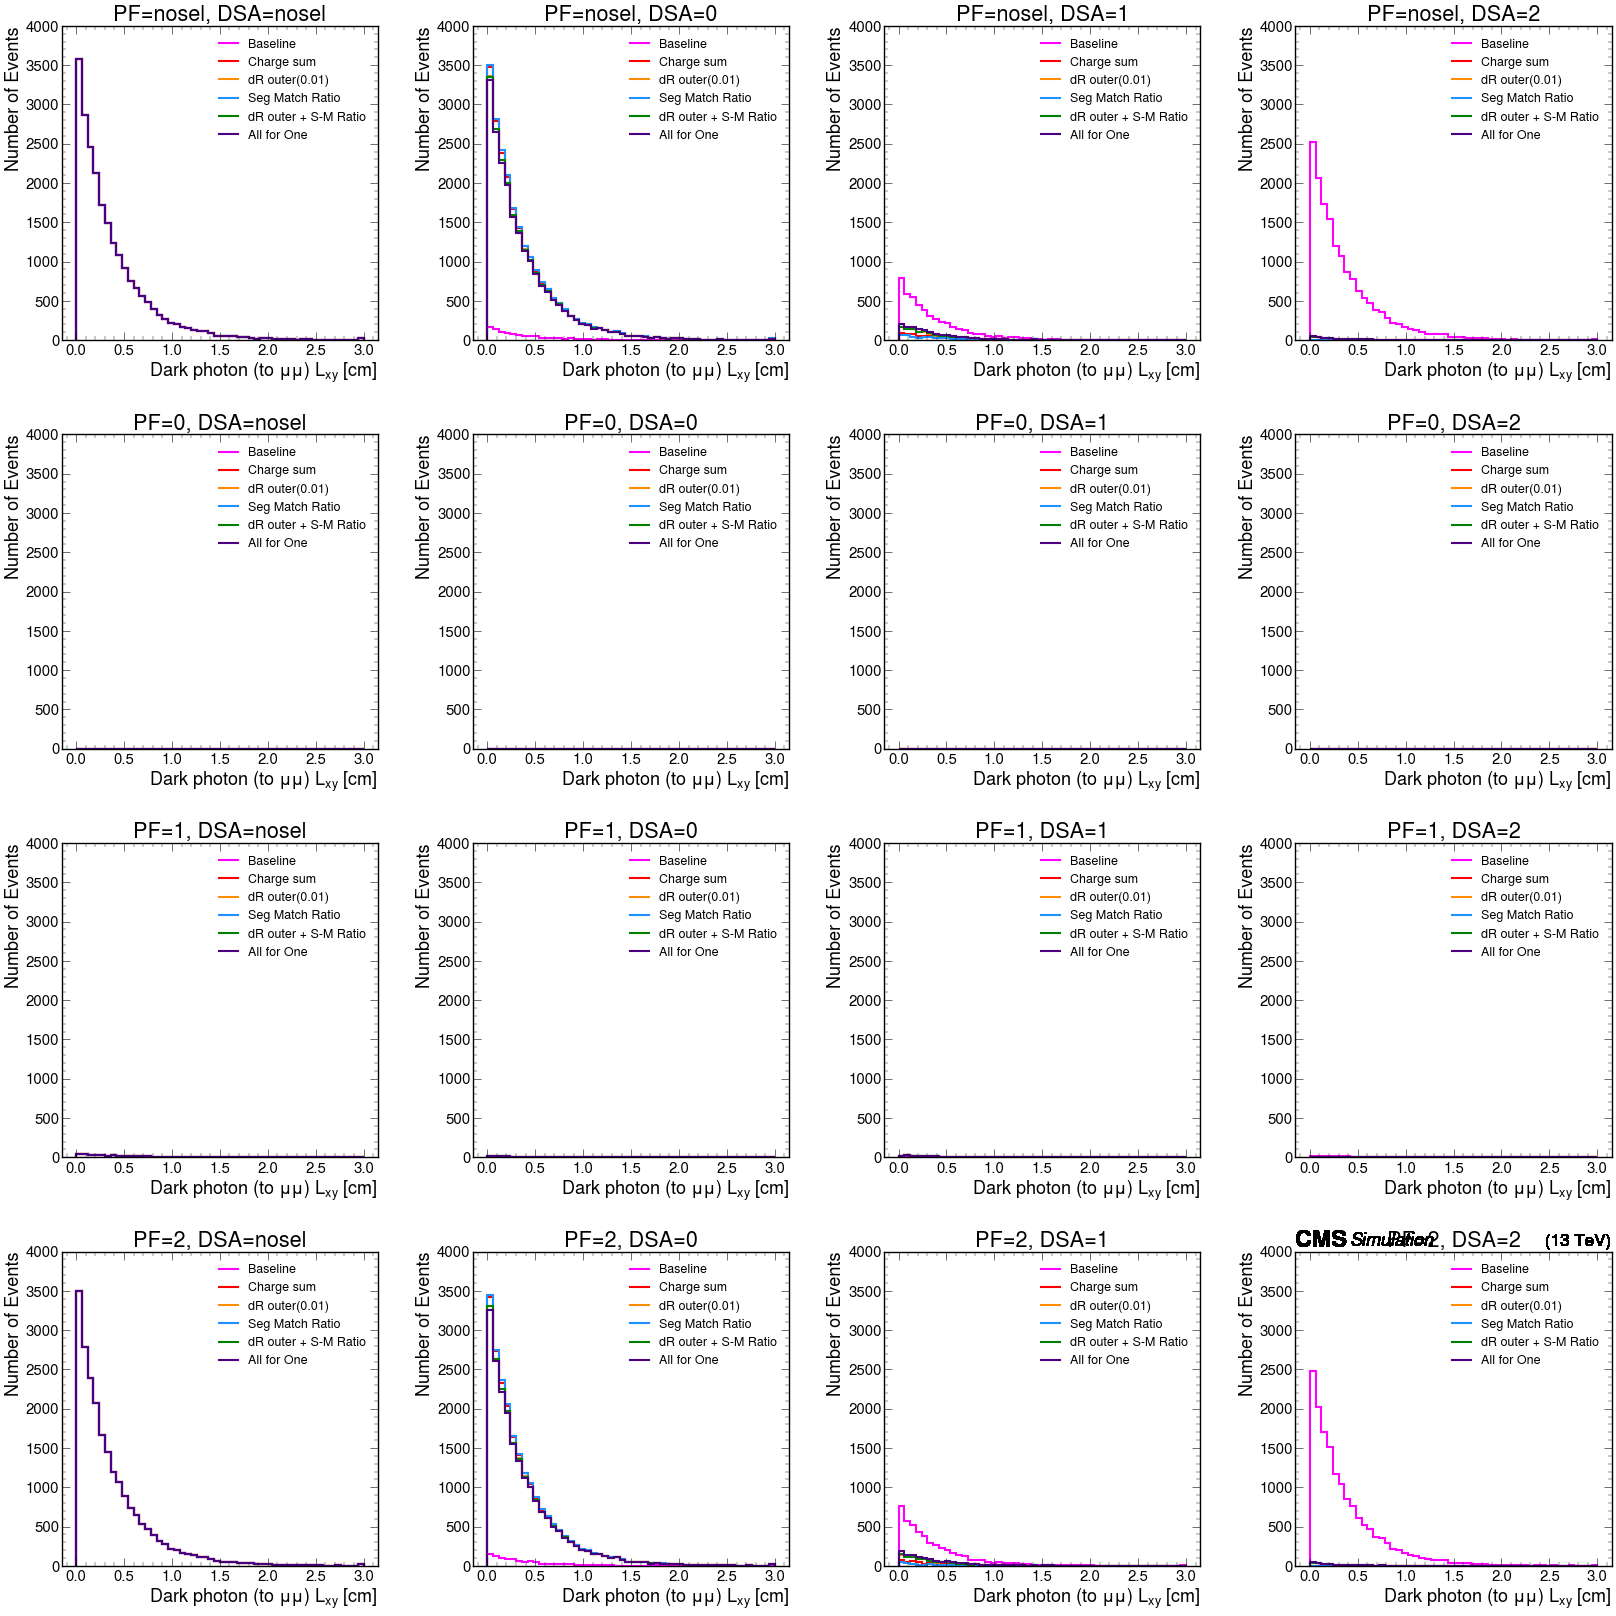

In [23]:
sample = "2Mu2E_200GeV_5p0GeV_0p2mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 4000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_8516/2975179086.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")


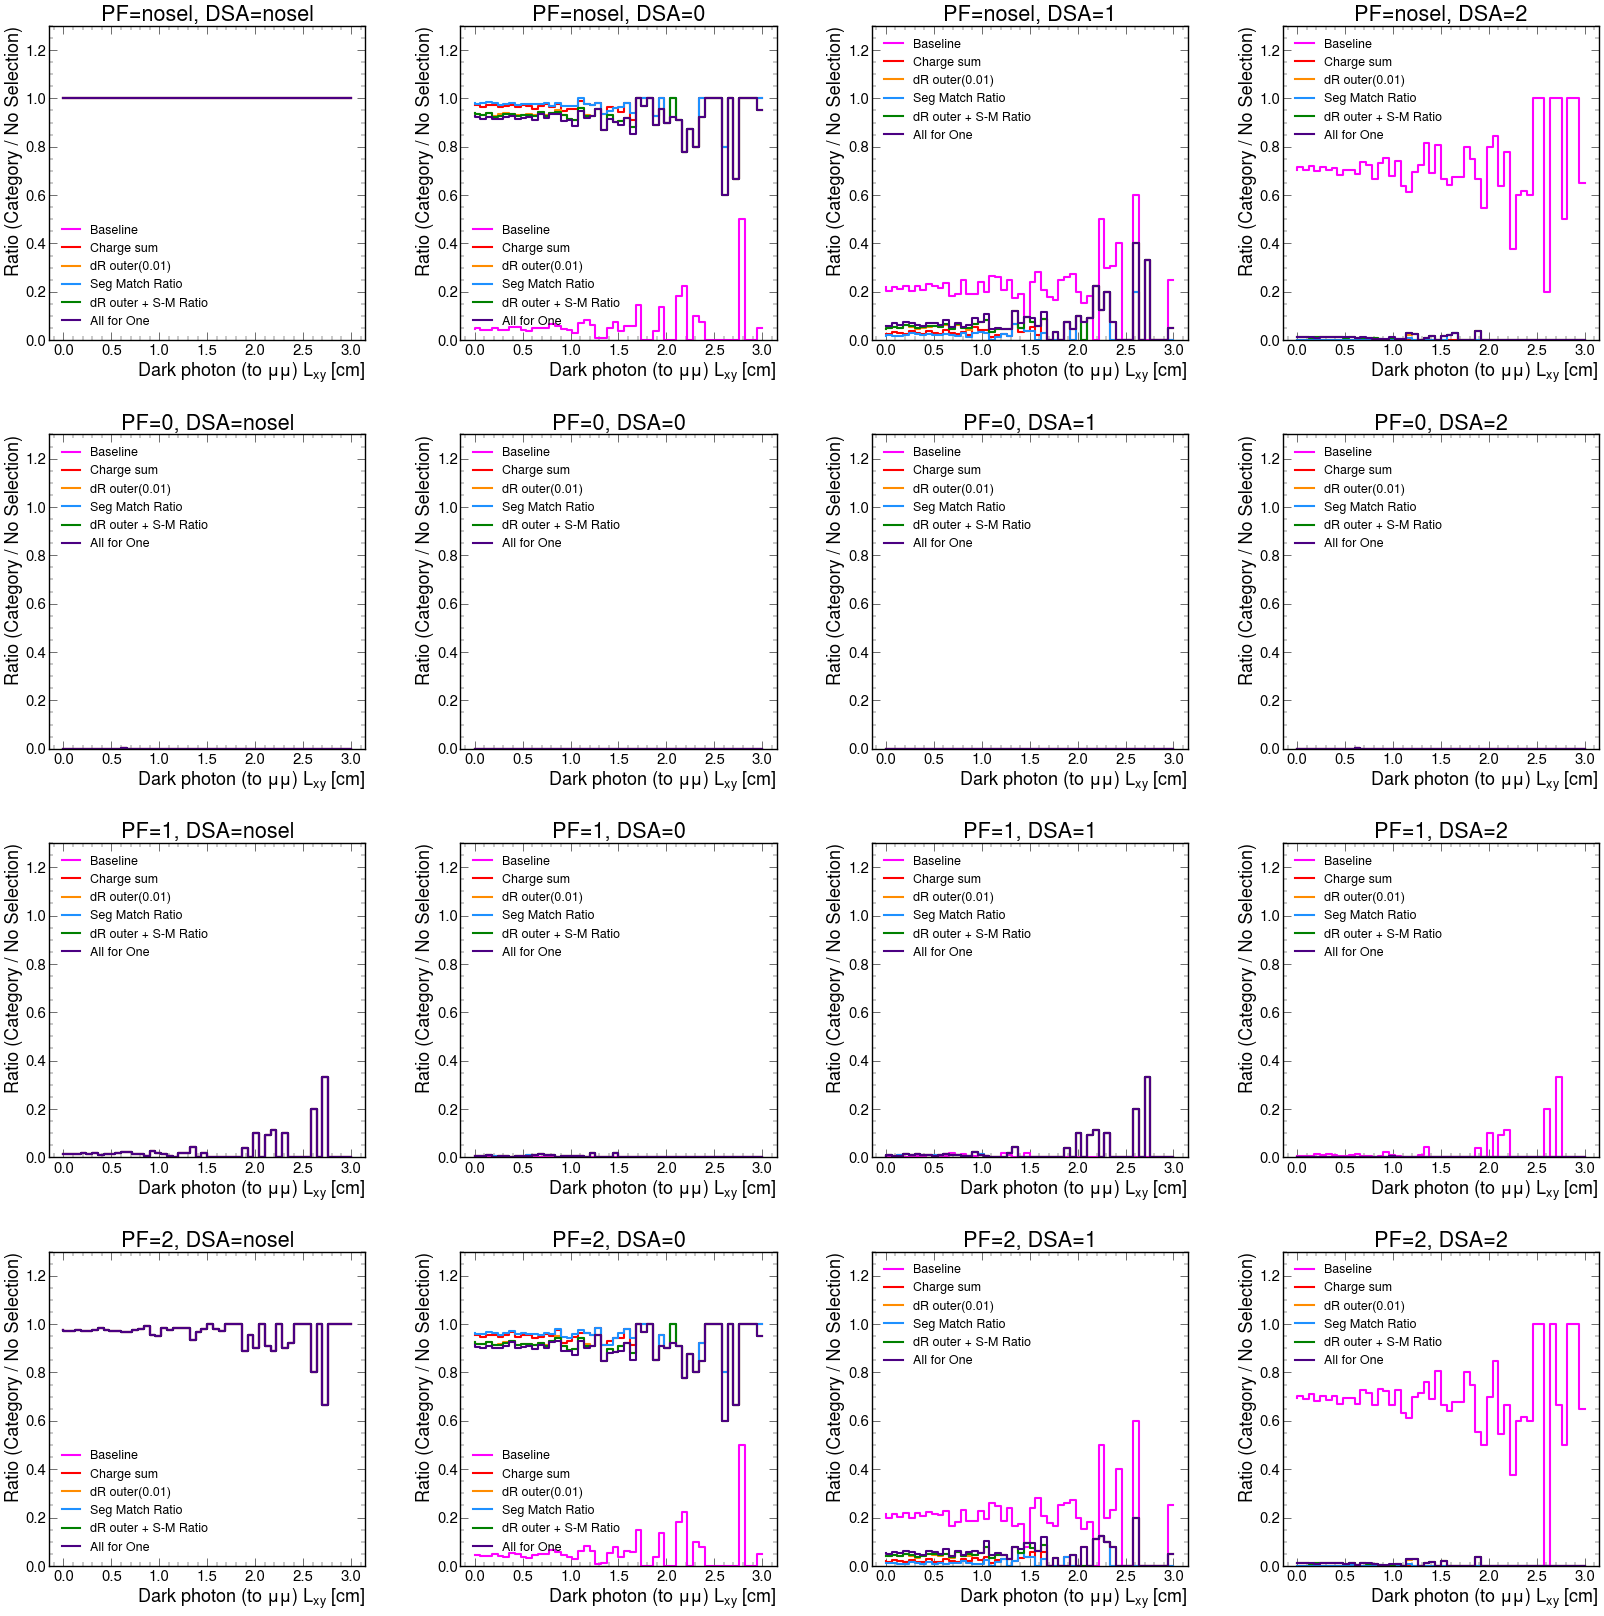

In [10]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_DP_matching", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_DP_matching", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_ylim(0, 1.3)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i in [0,1,12,13]:
        ax.legend(loc='lower left', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

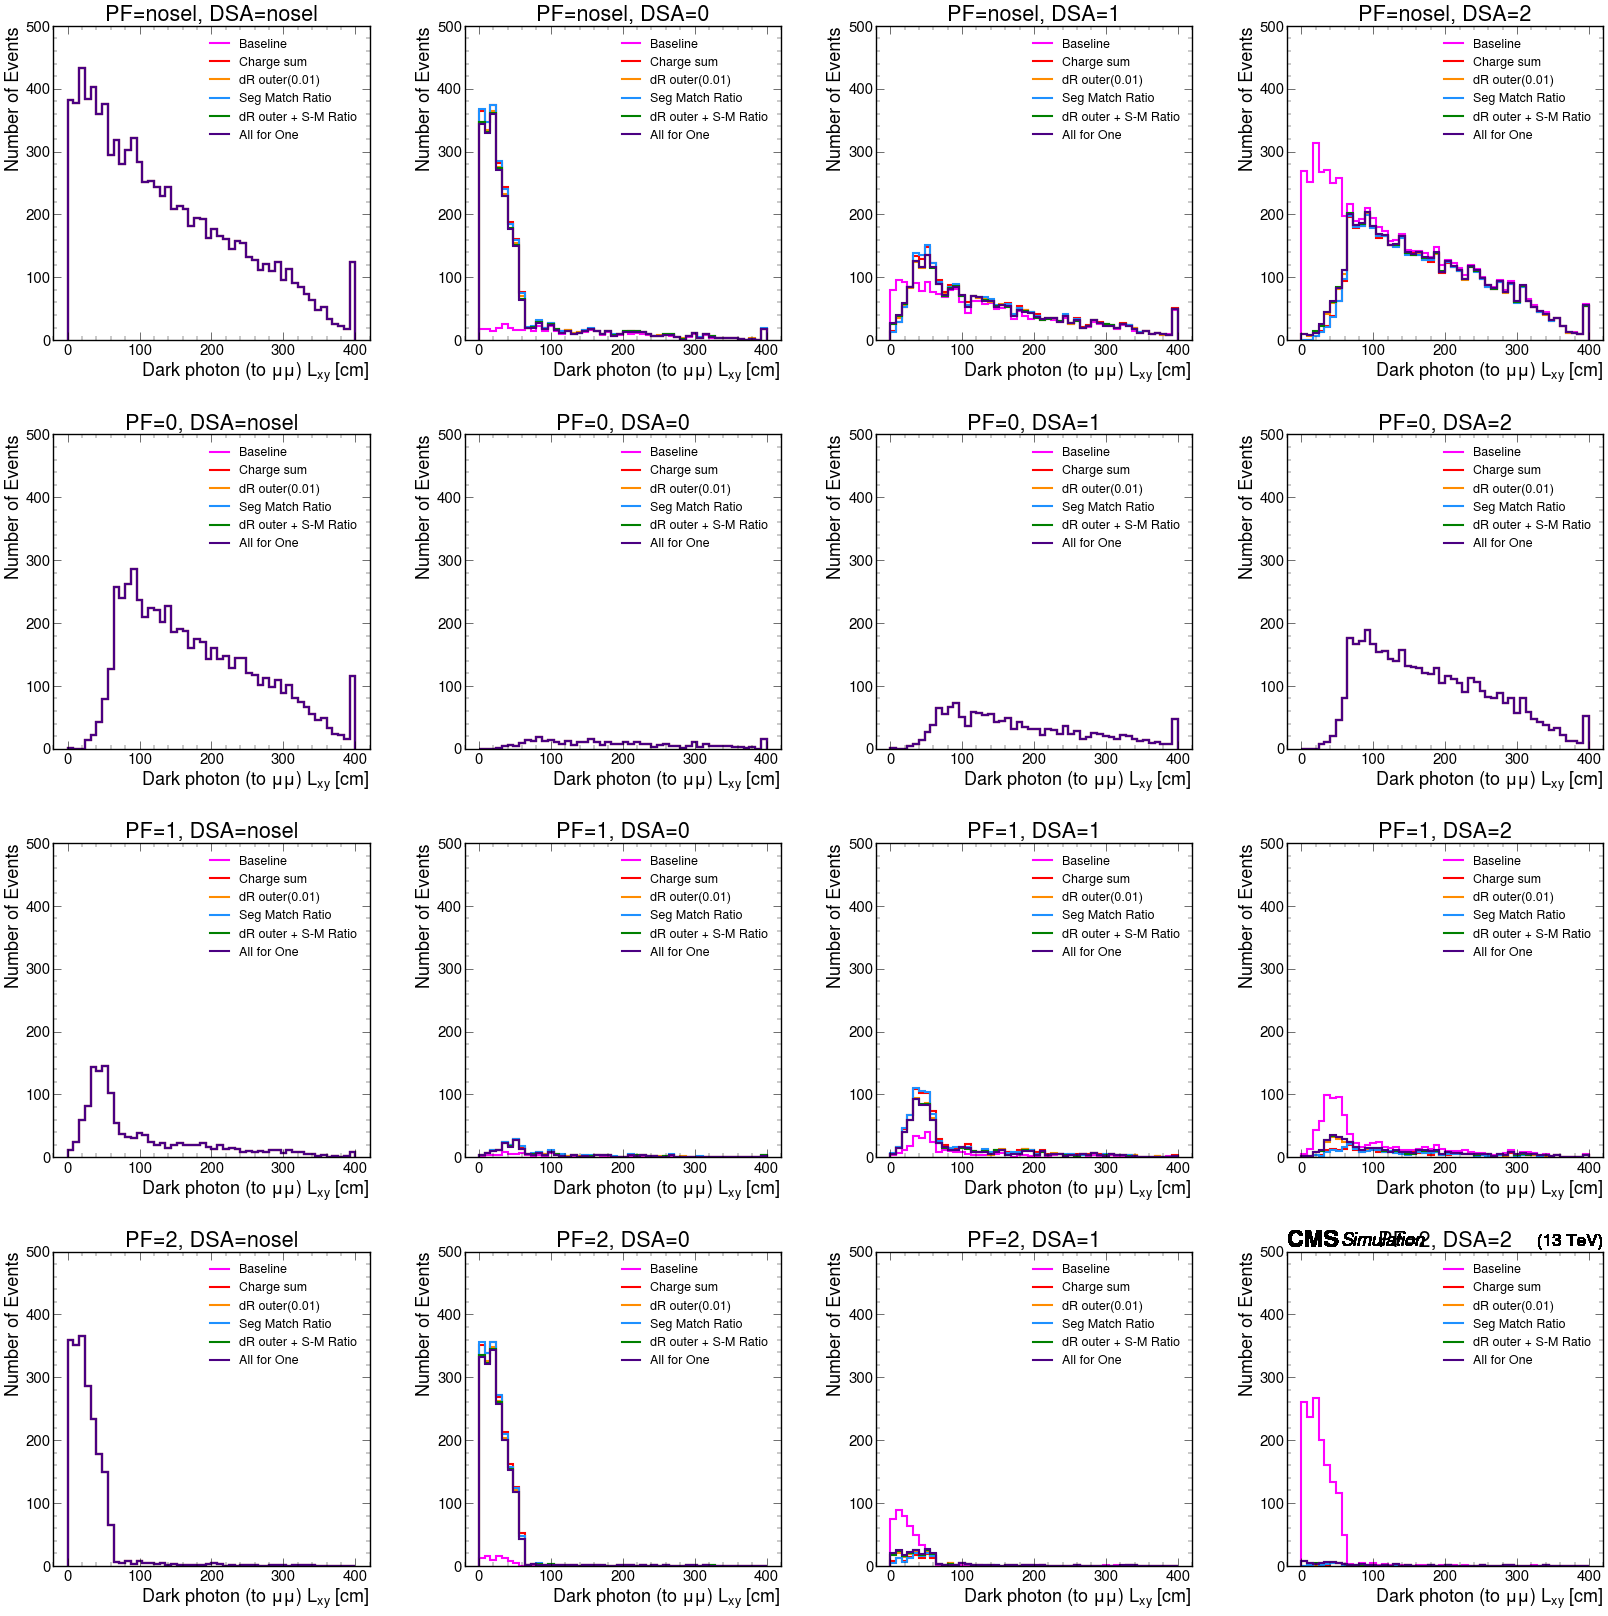

In [11]:
sample = "2Mu2E_200GeV_5p0GeV_200p0mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx],color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 500)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_8516/2185366208.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")


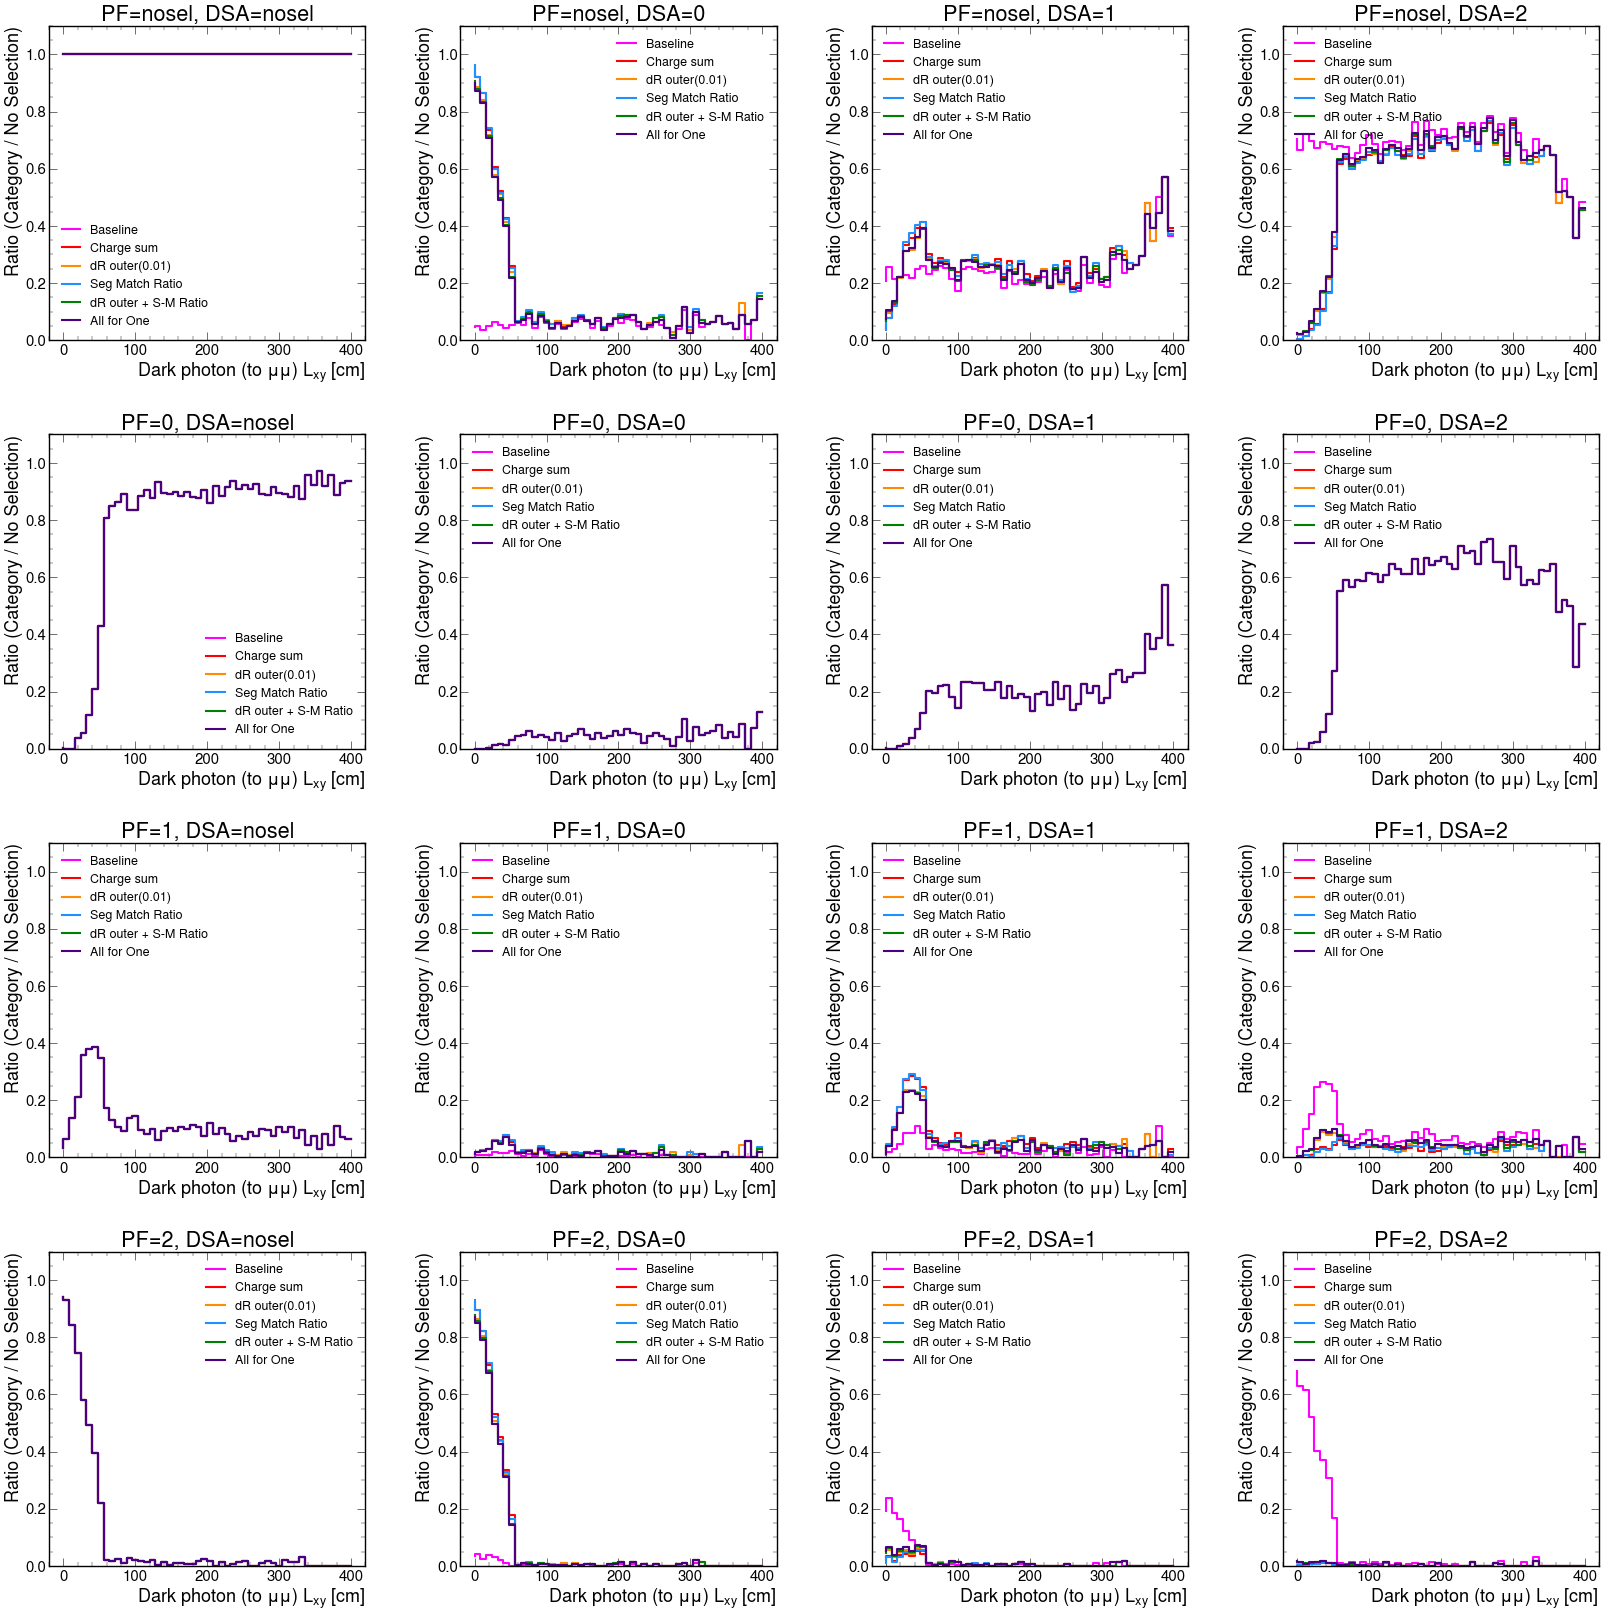

In [12]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_DP_matching", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_DP_matching", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx],color=colors[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i in [1,12,13]:
        ax.legend(loc='upper right', fontsize=18)
    elif i == 4:
        ax.legend(loc='lower right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

In [13]:
histnames = [
    "lj_lj_invmass_nosel", "lj_lj_invmass_noDSA", "lj_lj_invmass_oneDSA", "lj_lj_invmass_twoDSA",
    "lj_lj_invmass_noPF", "lj_lj_invmass_noPF_noDSA", "lj_lj_invmass_noPF_oneDSA", "lj_lj_invmass_noPF_twoDSA",
    "lj_lj_invmass_onePF", "lj_lj_invmass_onePF_noDSA", "lj_lj_invmass_onePF_oneDSA", "lj_lj_invmass_onePF_twoDSA",
    "lj_lj_invmass_twoPF", "lj_lj_invmass_twoPF_noDSA", "lj_lj_invmass_twoPF_oneDSA", "lj_lj_invmass_twoPF_twoDSA"
]

histnames_ptratio = [
    "lj_dp_pt_ratio_nosel", "lj_dp_pt_ratio_noDSA", "lj_dp_pt_ratio_oneDSA", "lj_dp_pt_ratio_twoDSA",
    "lj_dp_pt_ratio_noPF", "lj_dp_pt_ratio_noPF_noDSA", "lj_dp_pt_ratio_noPF_oneDSA", "lj_dp_pt_ratio_noPF_twoDSA",
    "lj_dp_pt_ratio_onePF", "lj_dp_pt_ratio_onePF_noDSA", "lj_dp_pt_ratio_onePF_oneDSA", "lj_dp_pt_ratio_onePF_twoDSA",
    "lj_dp_pt_ratio_twoPF", "lj_dp_pt_ratio_twoPF_noDSA", "lj_dp_pt_ratio_twoPF_oneDSA", "lj_dp_pt_ratio_twoPF_twoDSA"
]

histtitle= ["PF=nosel, DSA=nosel", "PF=nosel, DSA=0", "PF=nosel, DSA=1", "PF=nosel, DSA=2",
            "PF=0, DSA=nosel", "PF=0, DSA=0", "PF=0, DSA=1", "PF=0, DSA=2",
            "PF=1, DSA=nosel", "PF=1, DSA=0", "PF=1, DSA=1", "PF=1, DSA=2",
            "PF=2, DSA=nosel", "PF=2, DSA=0", "PF=2, DSA=1", "PF=2, DSA=2",
           ]

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


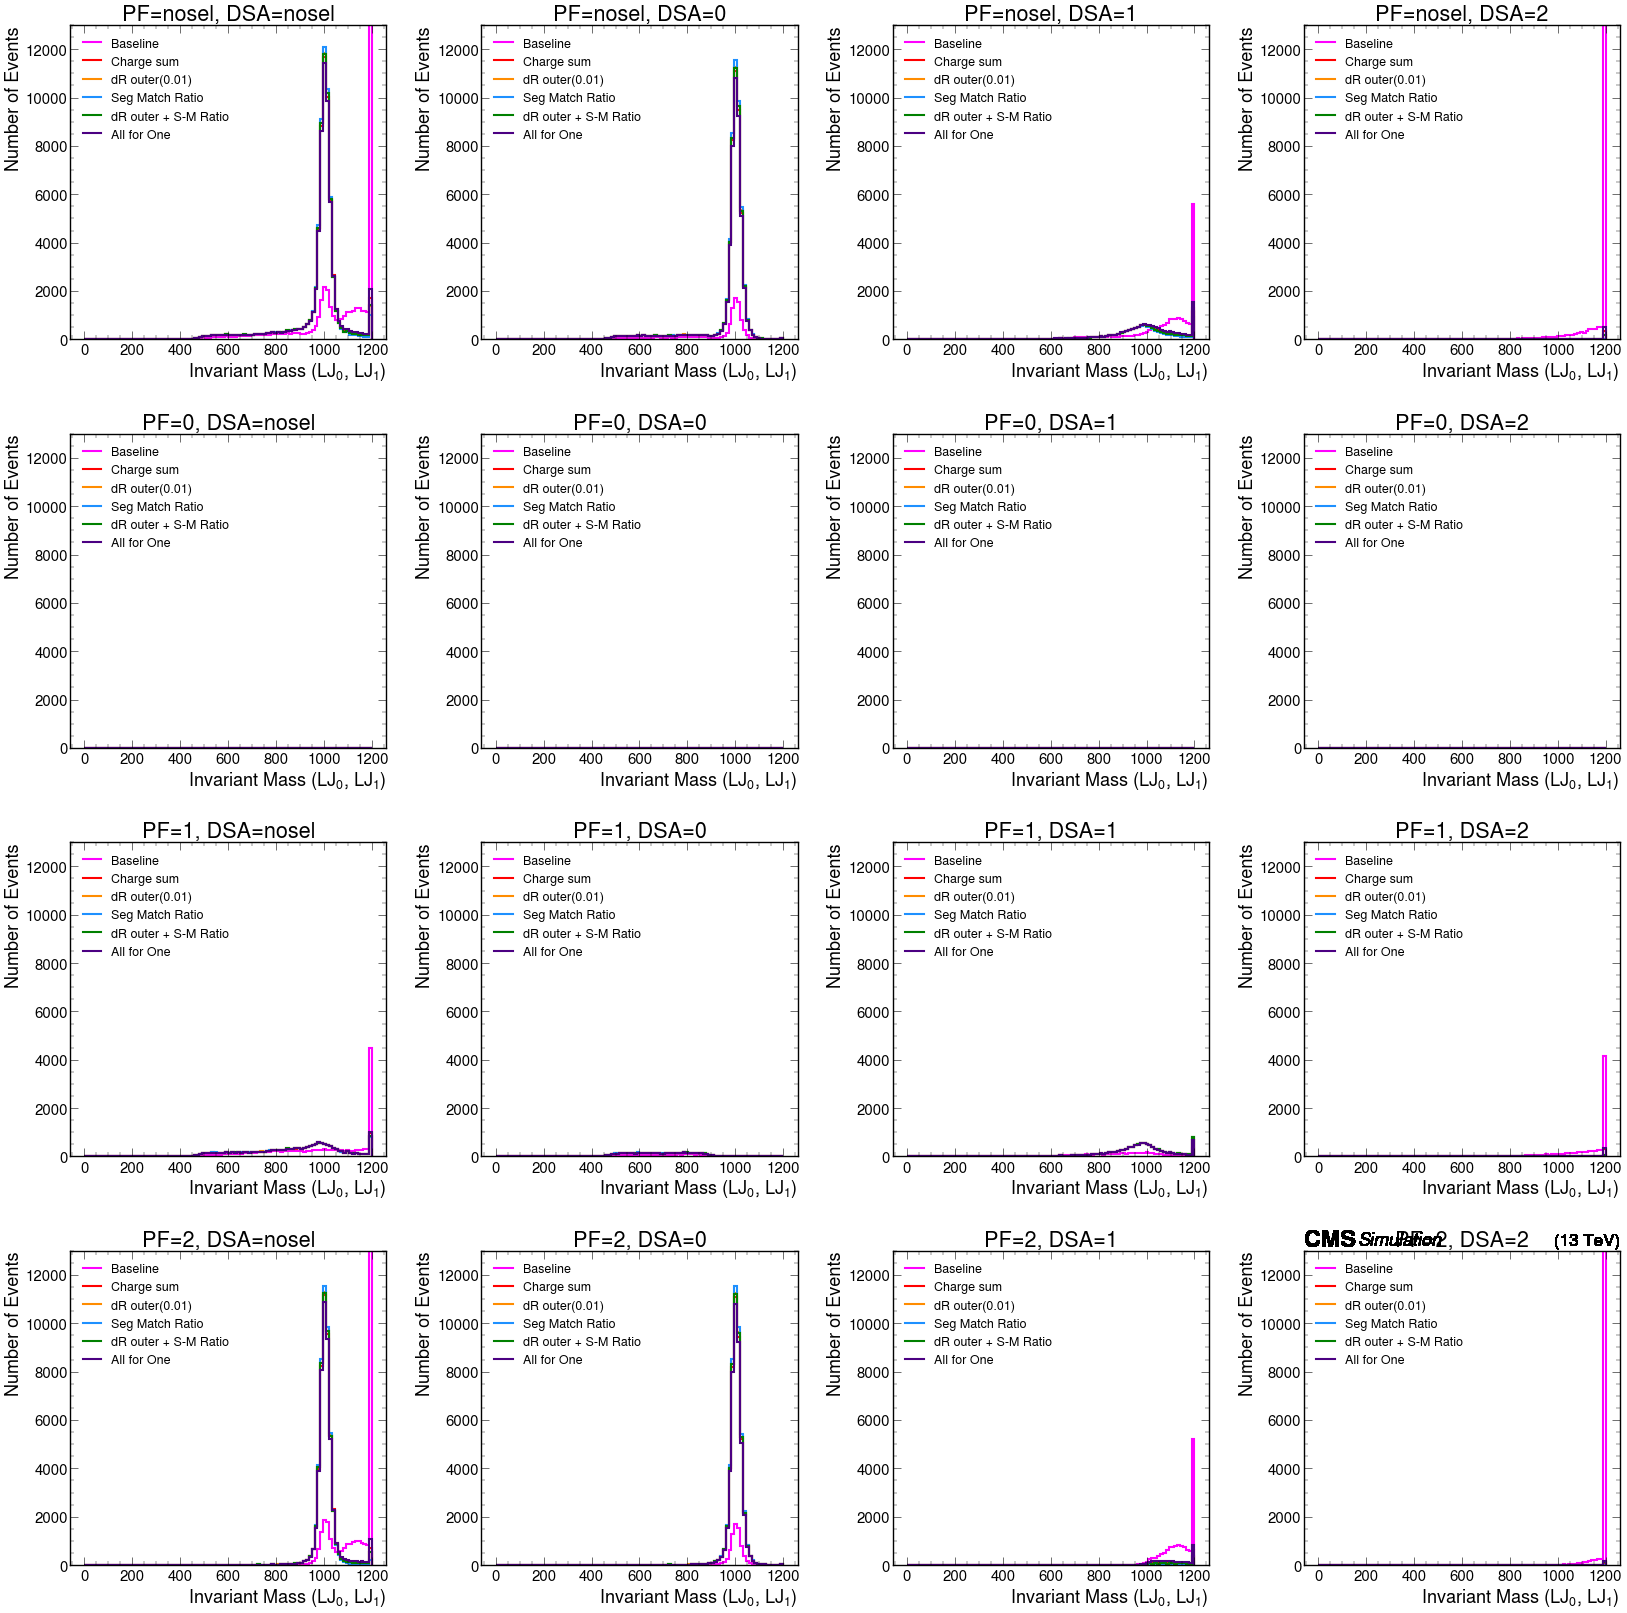

In [14]:
sample = "2Mu2E_1000GeV_0p25GeV_0p002mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 13000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


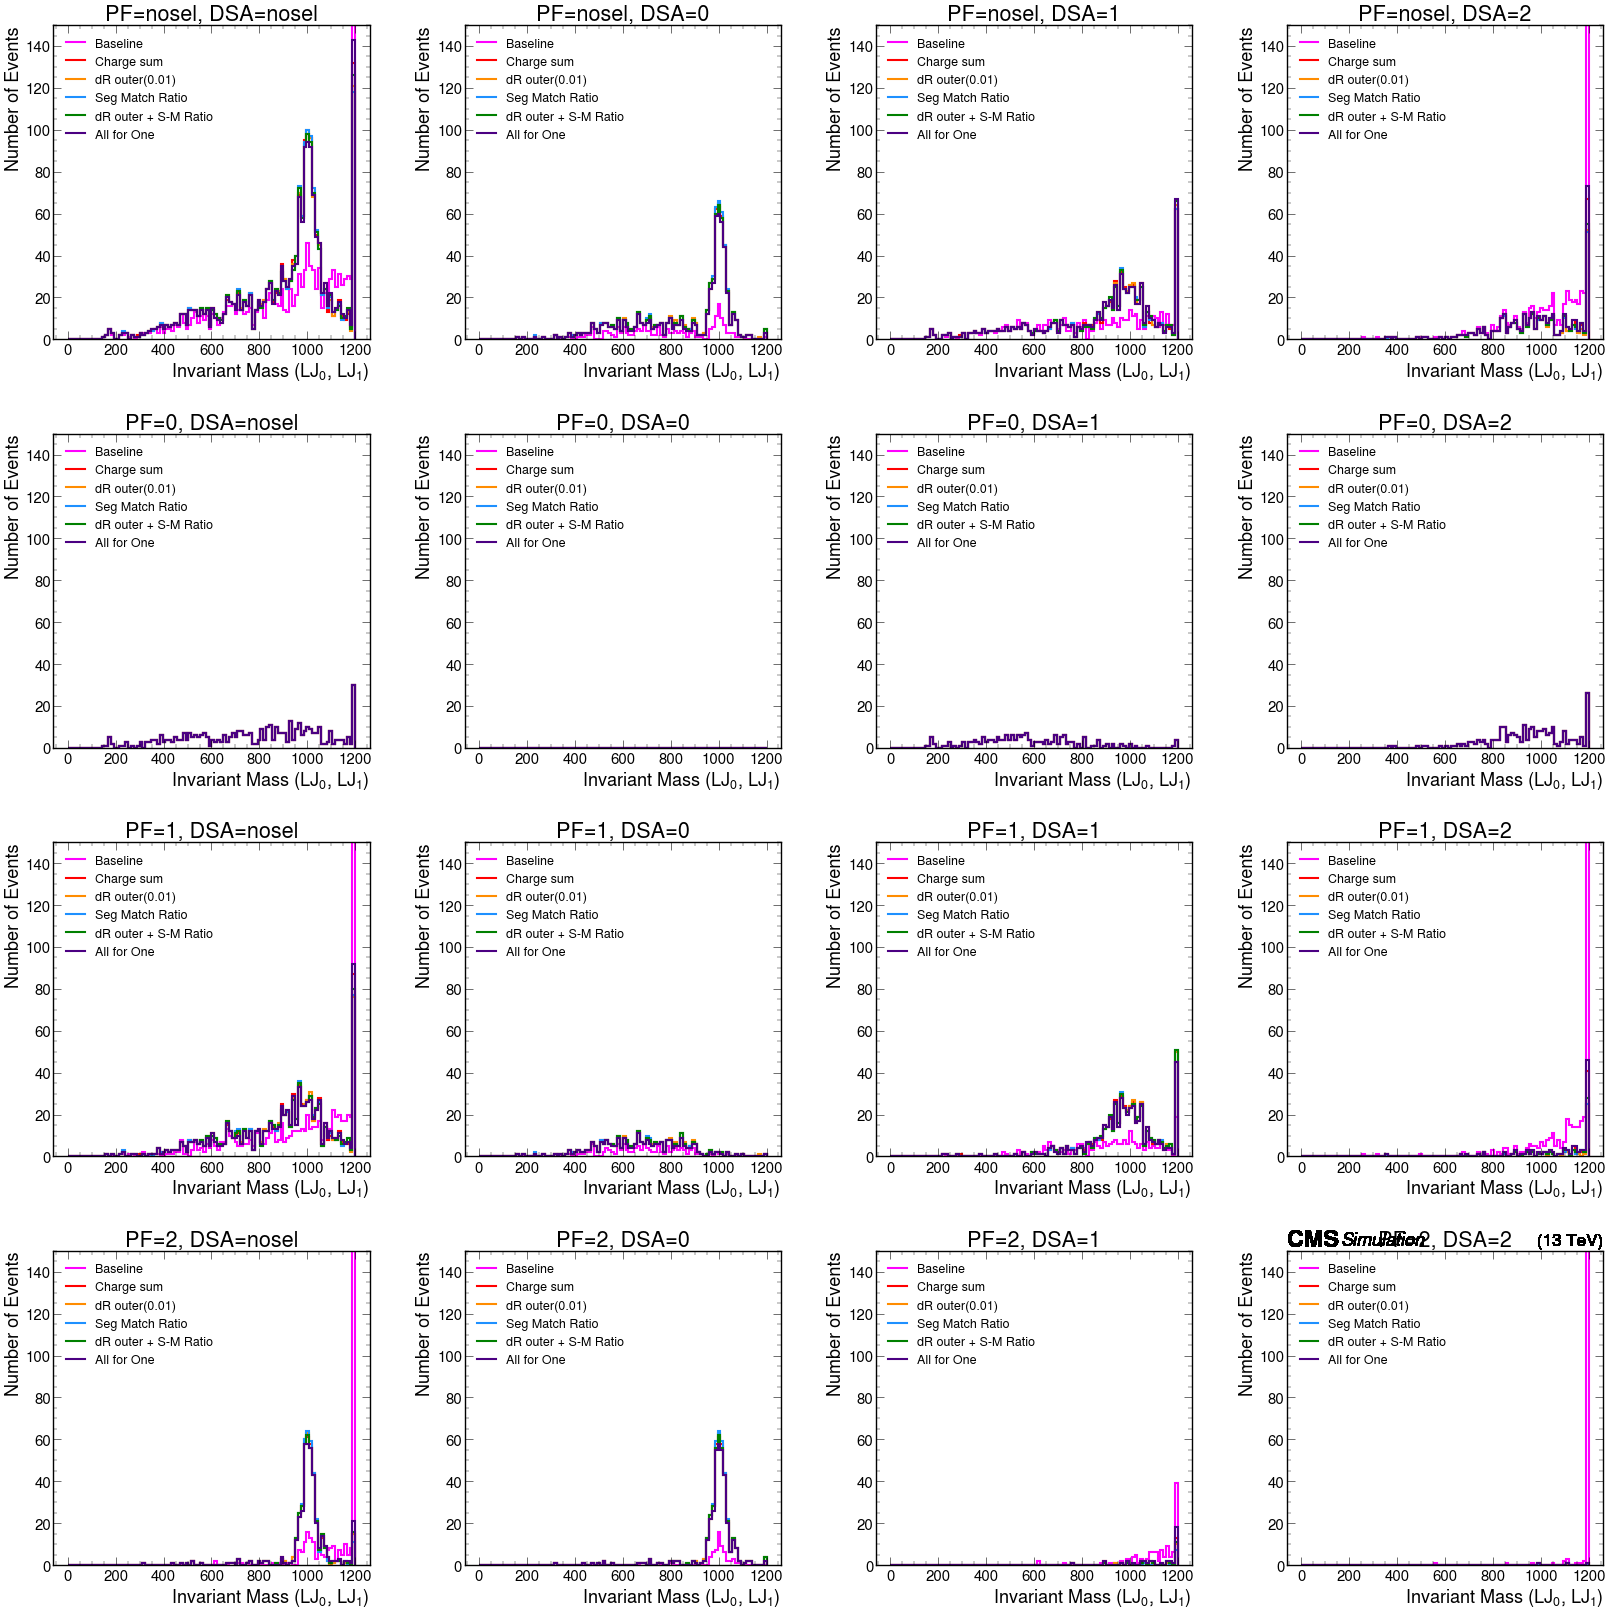

In [15]:
sample = "2Mu2E_1000GeV_0p25GeV_2p0mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 150)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


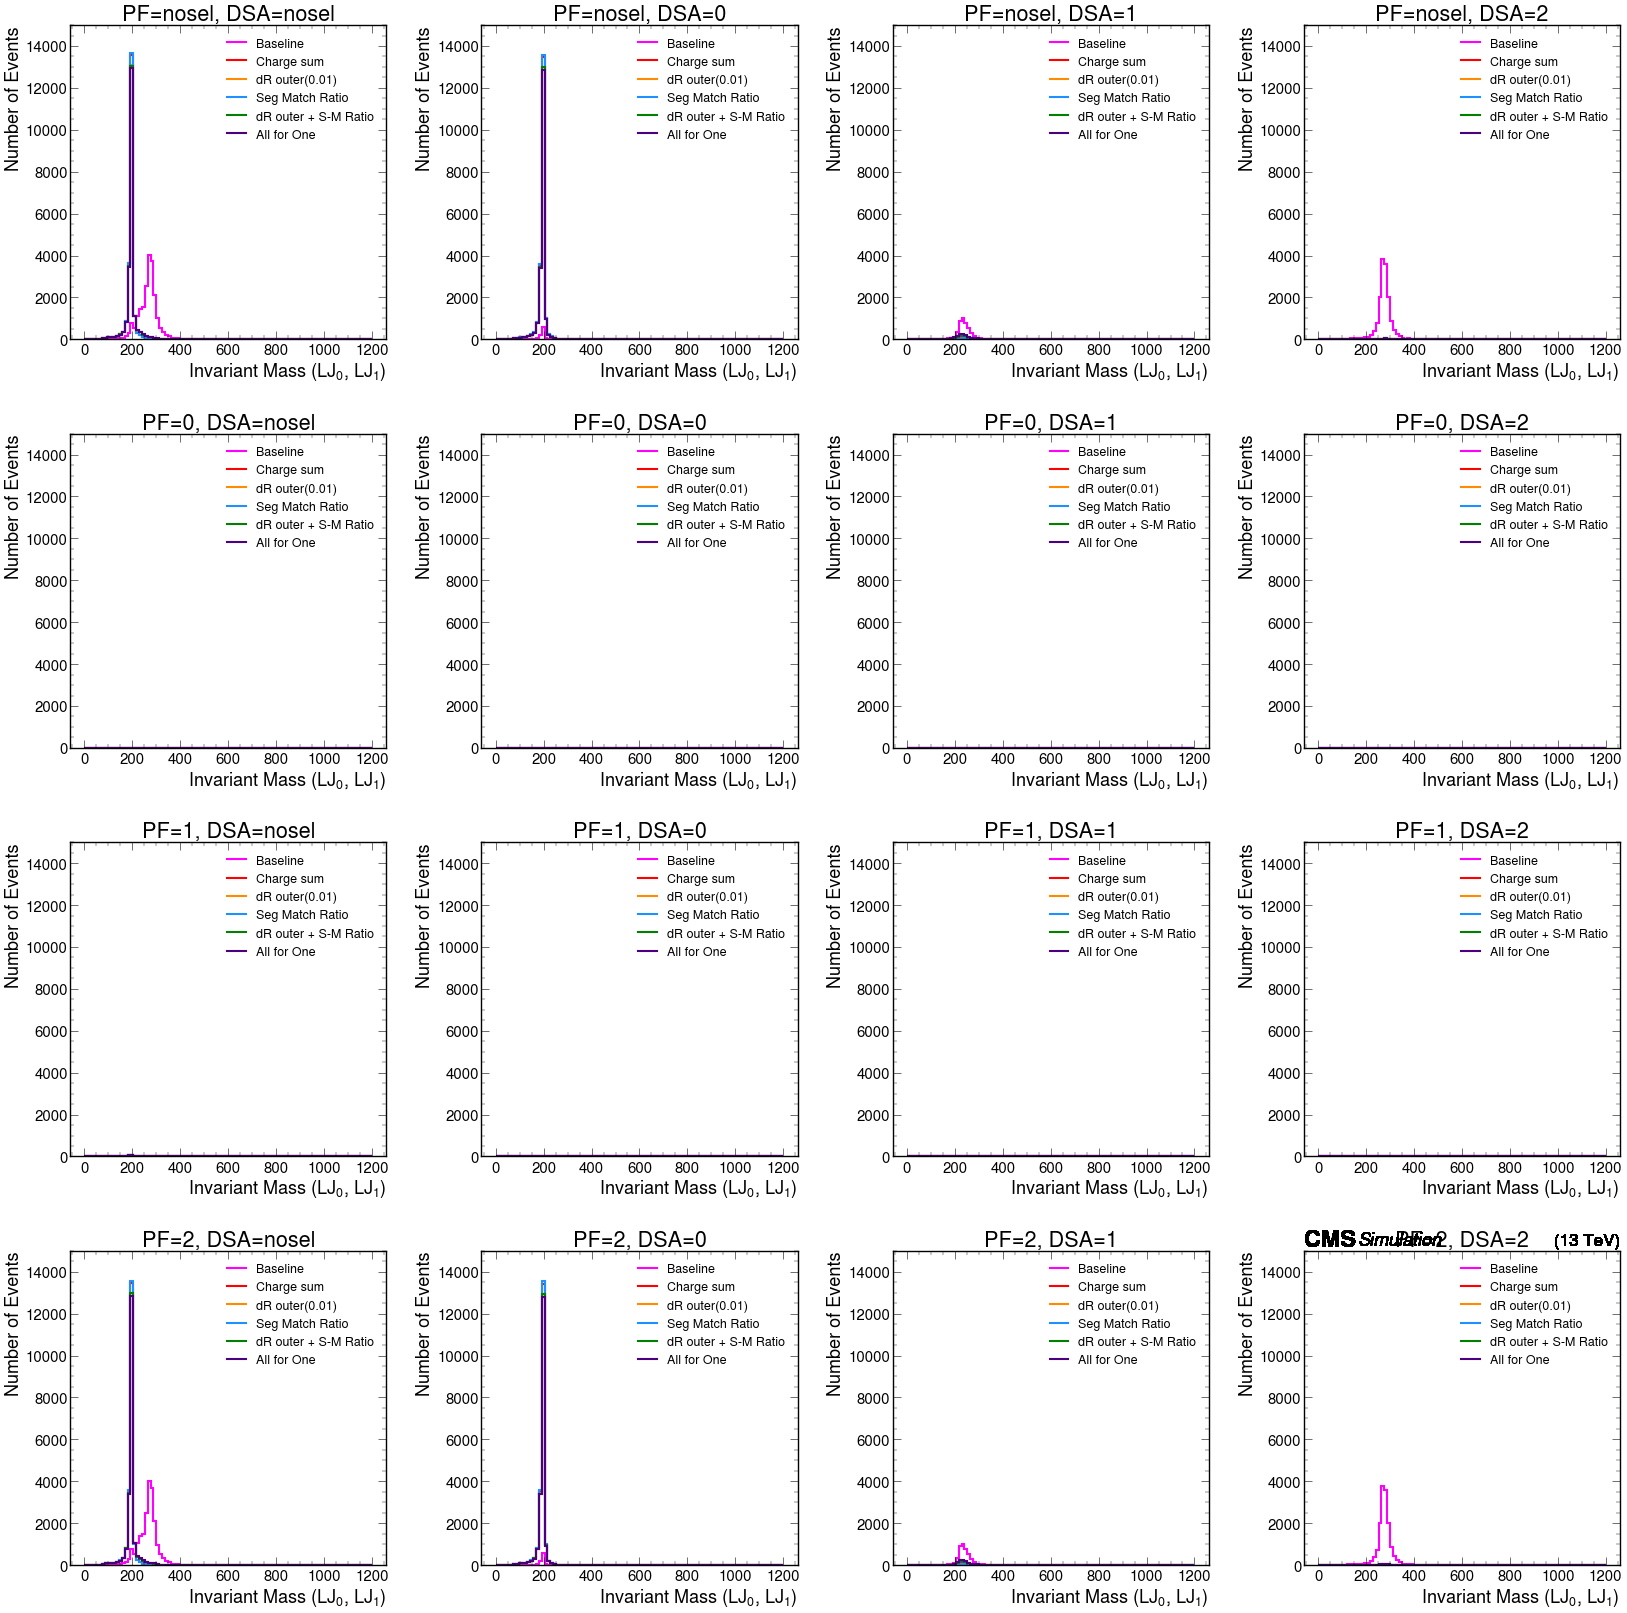

In [16]:
sample = "2Mu2E_200GeV_5p0GeV_0p2mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx],color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 15000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


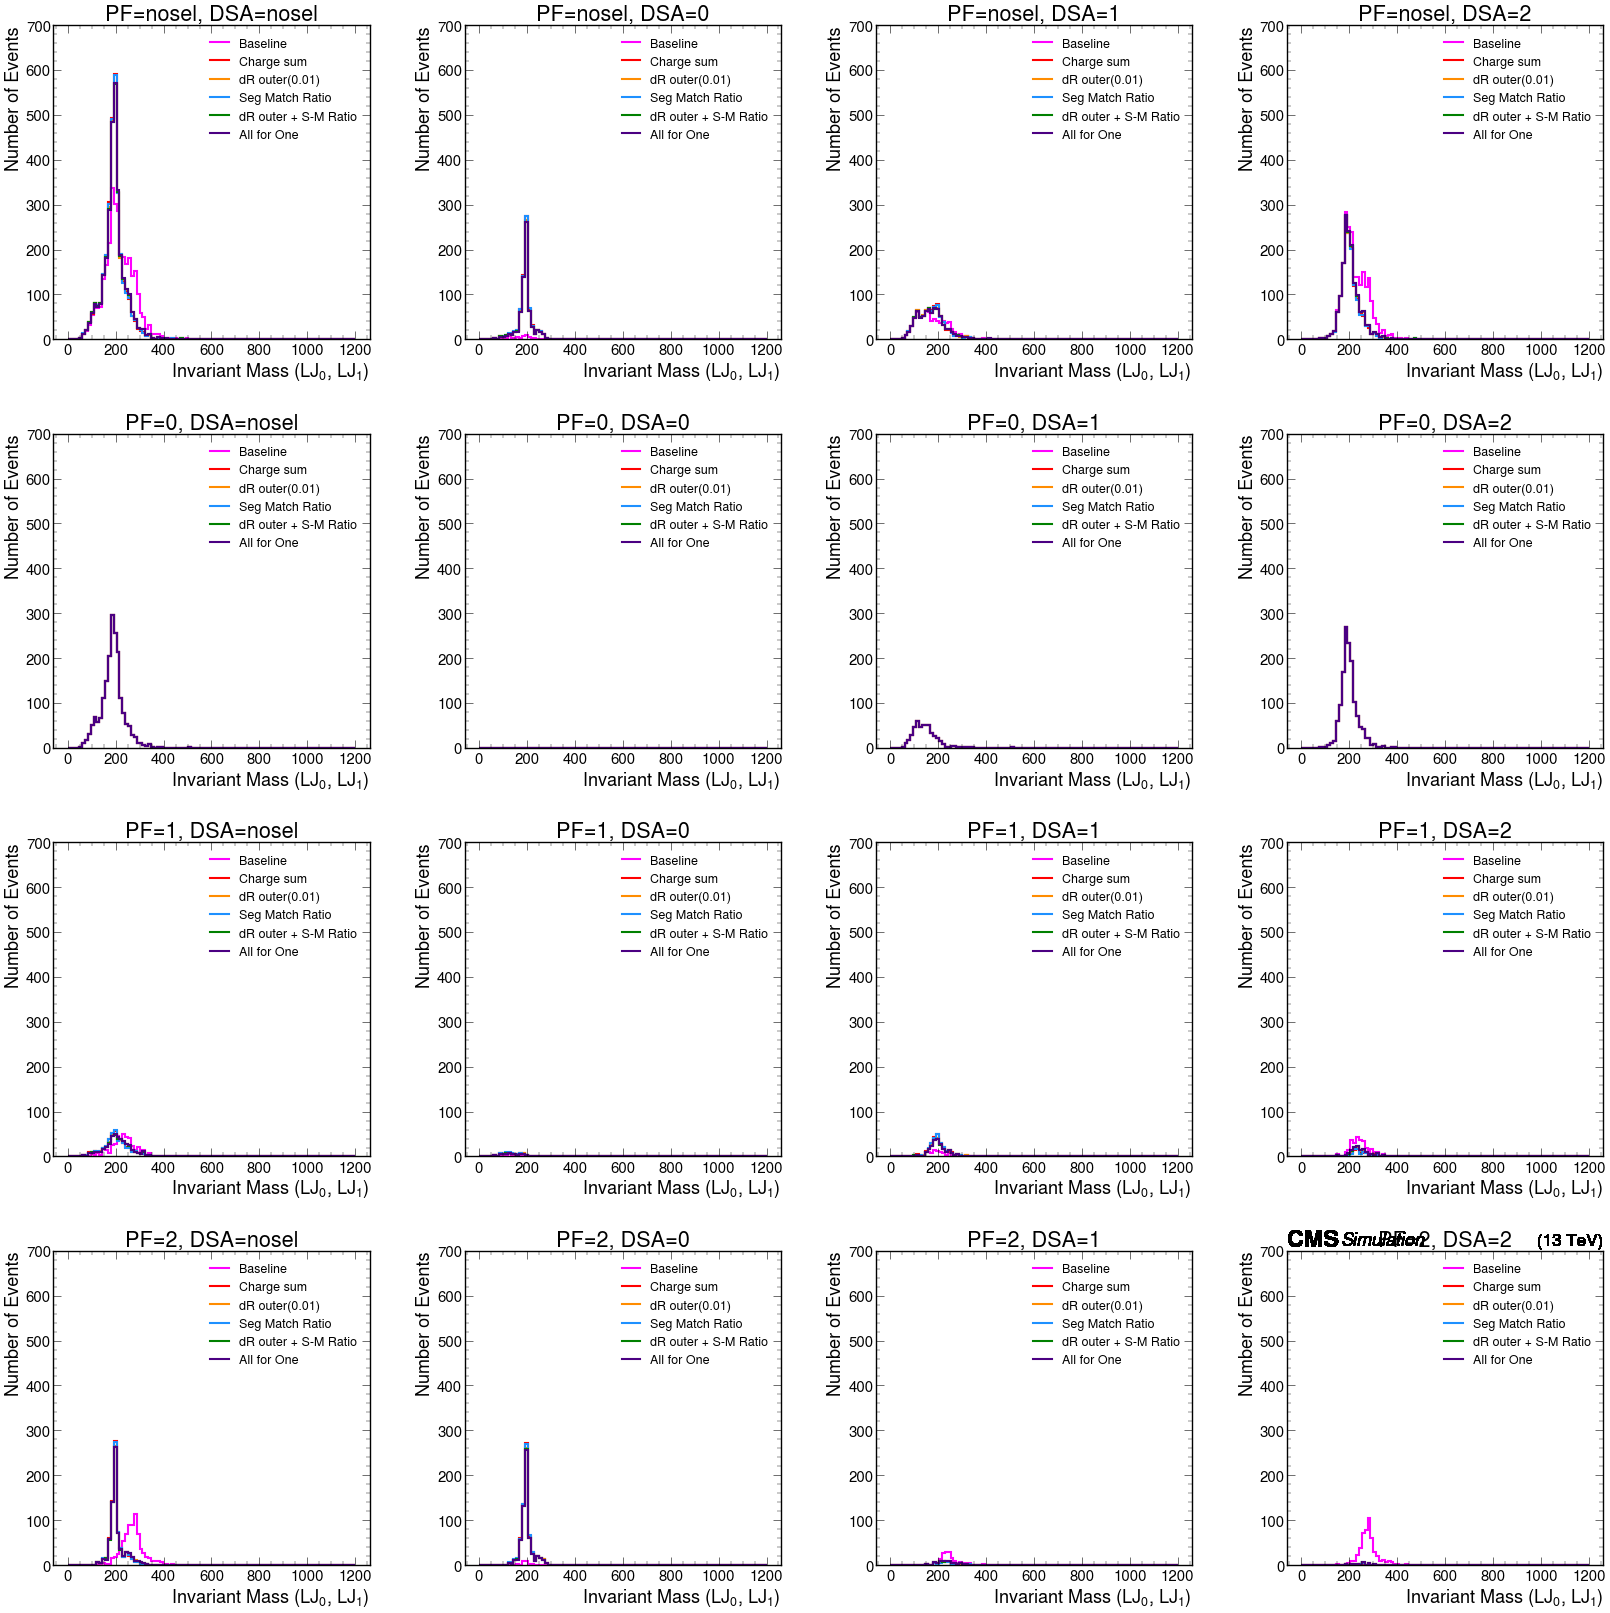

In [18]:
sample = "2Mu2E_200GeV_5p0GeV_200p0mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx],color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 700)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


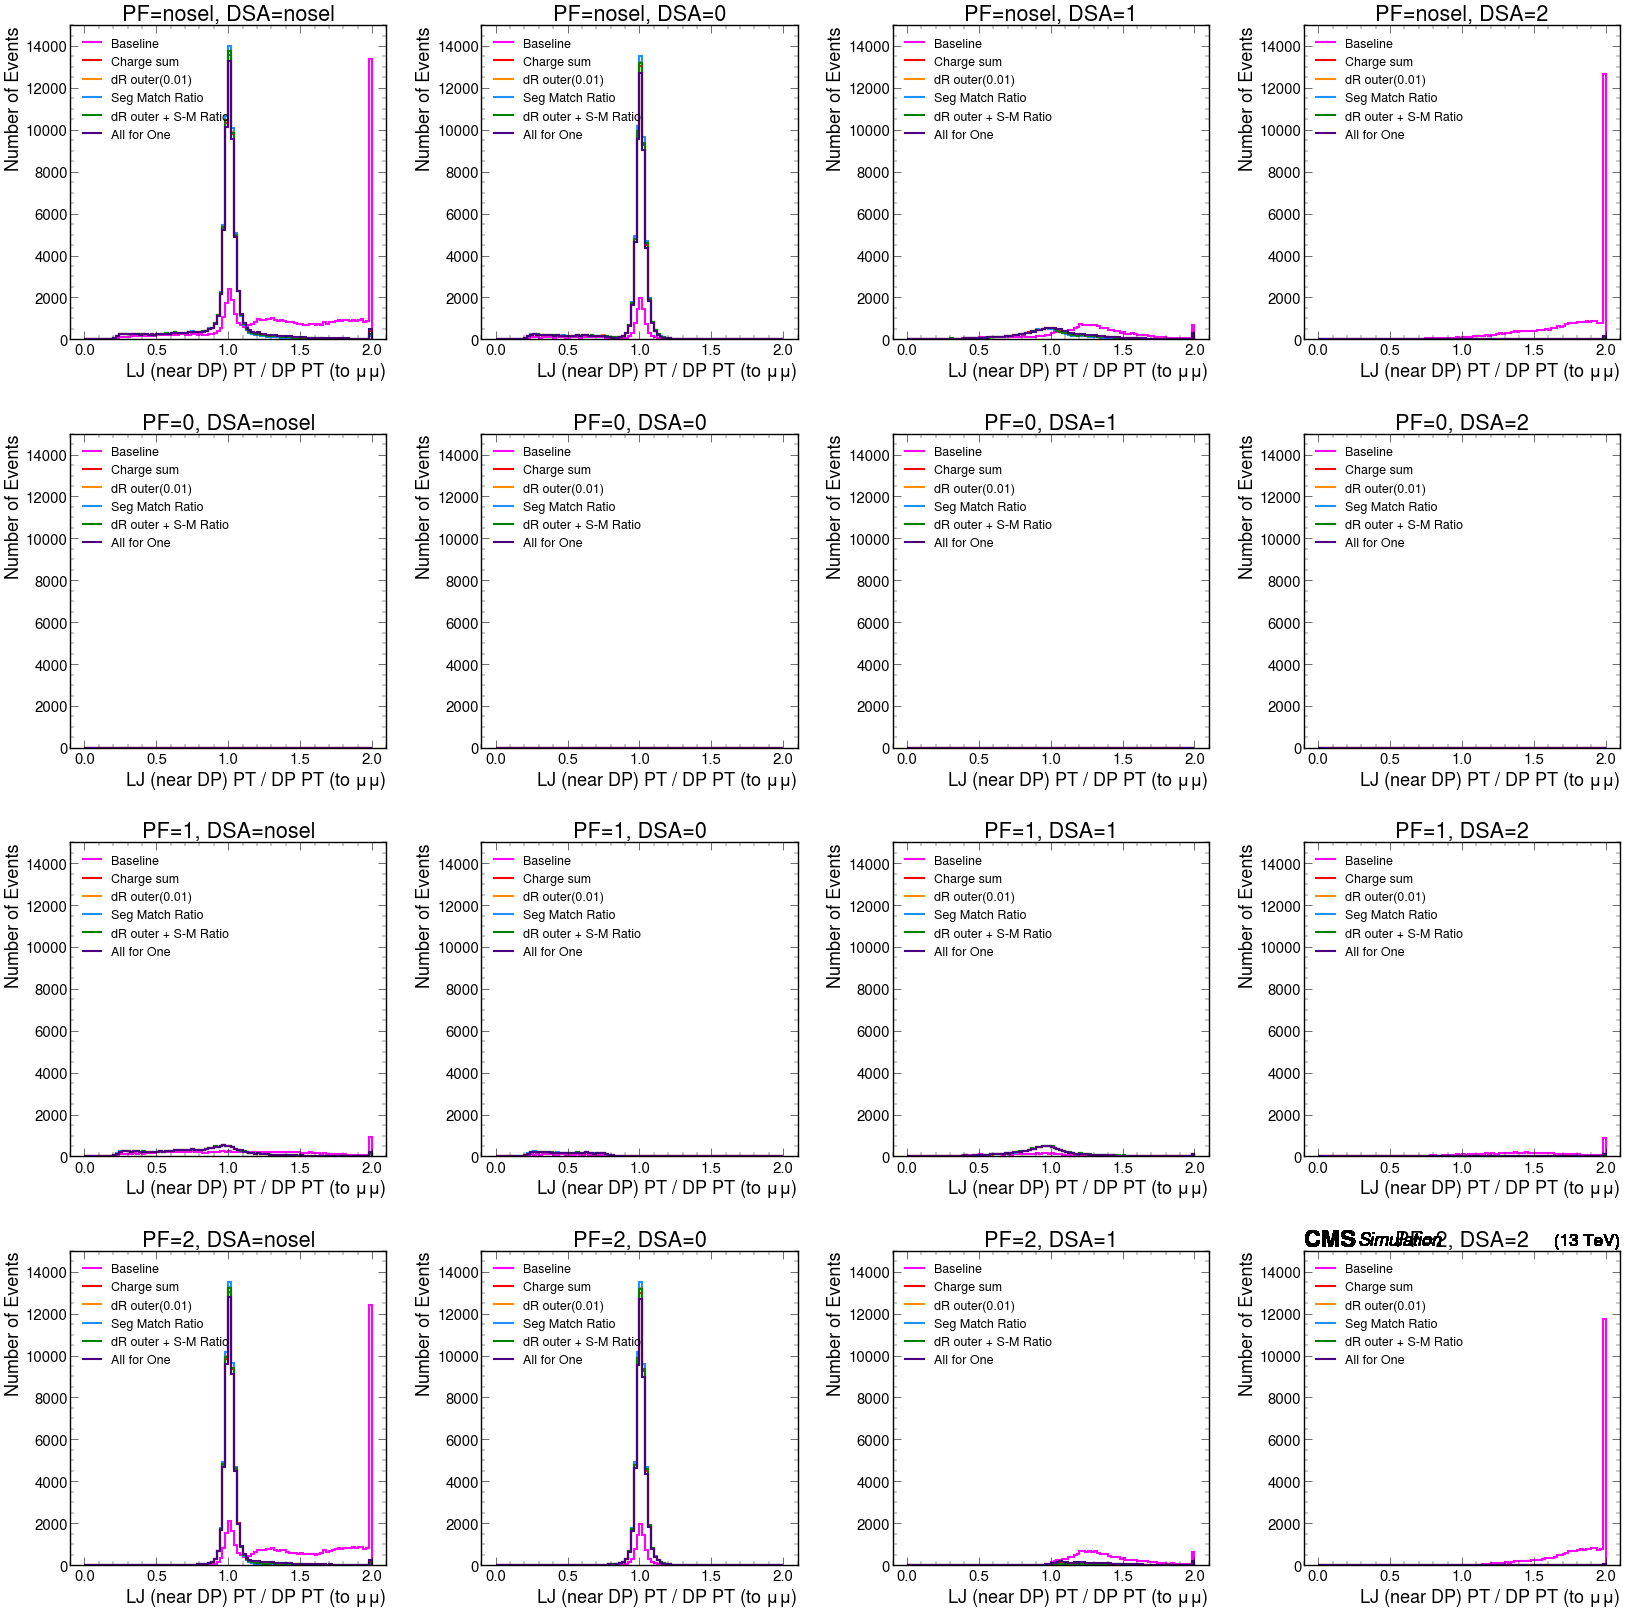

In [19]:
sample = "2Mu2E_1000GeV_0p25GeV_0p002mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_ptratio[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 15000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


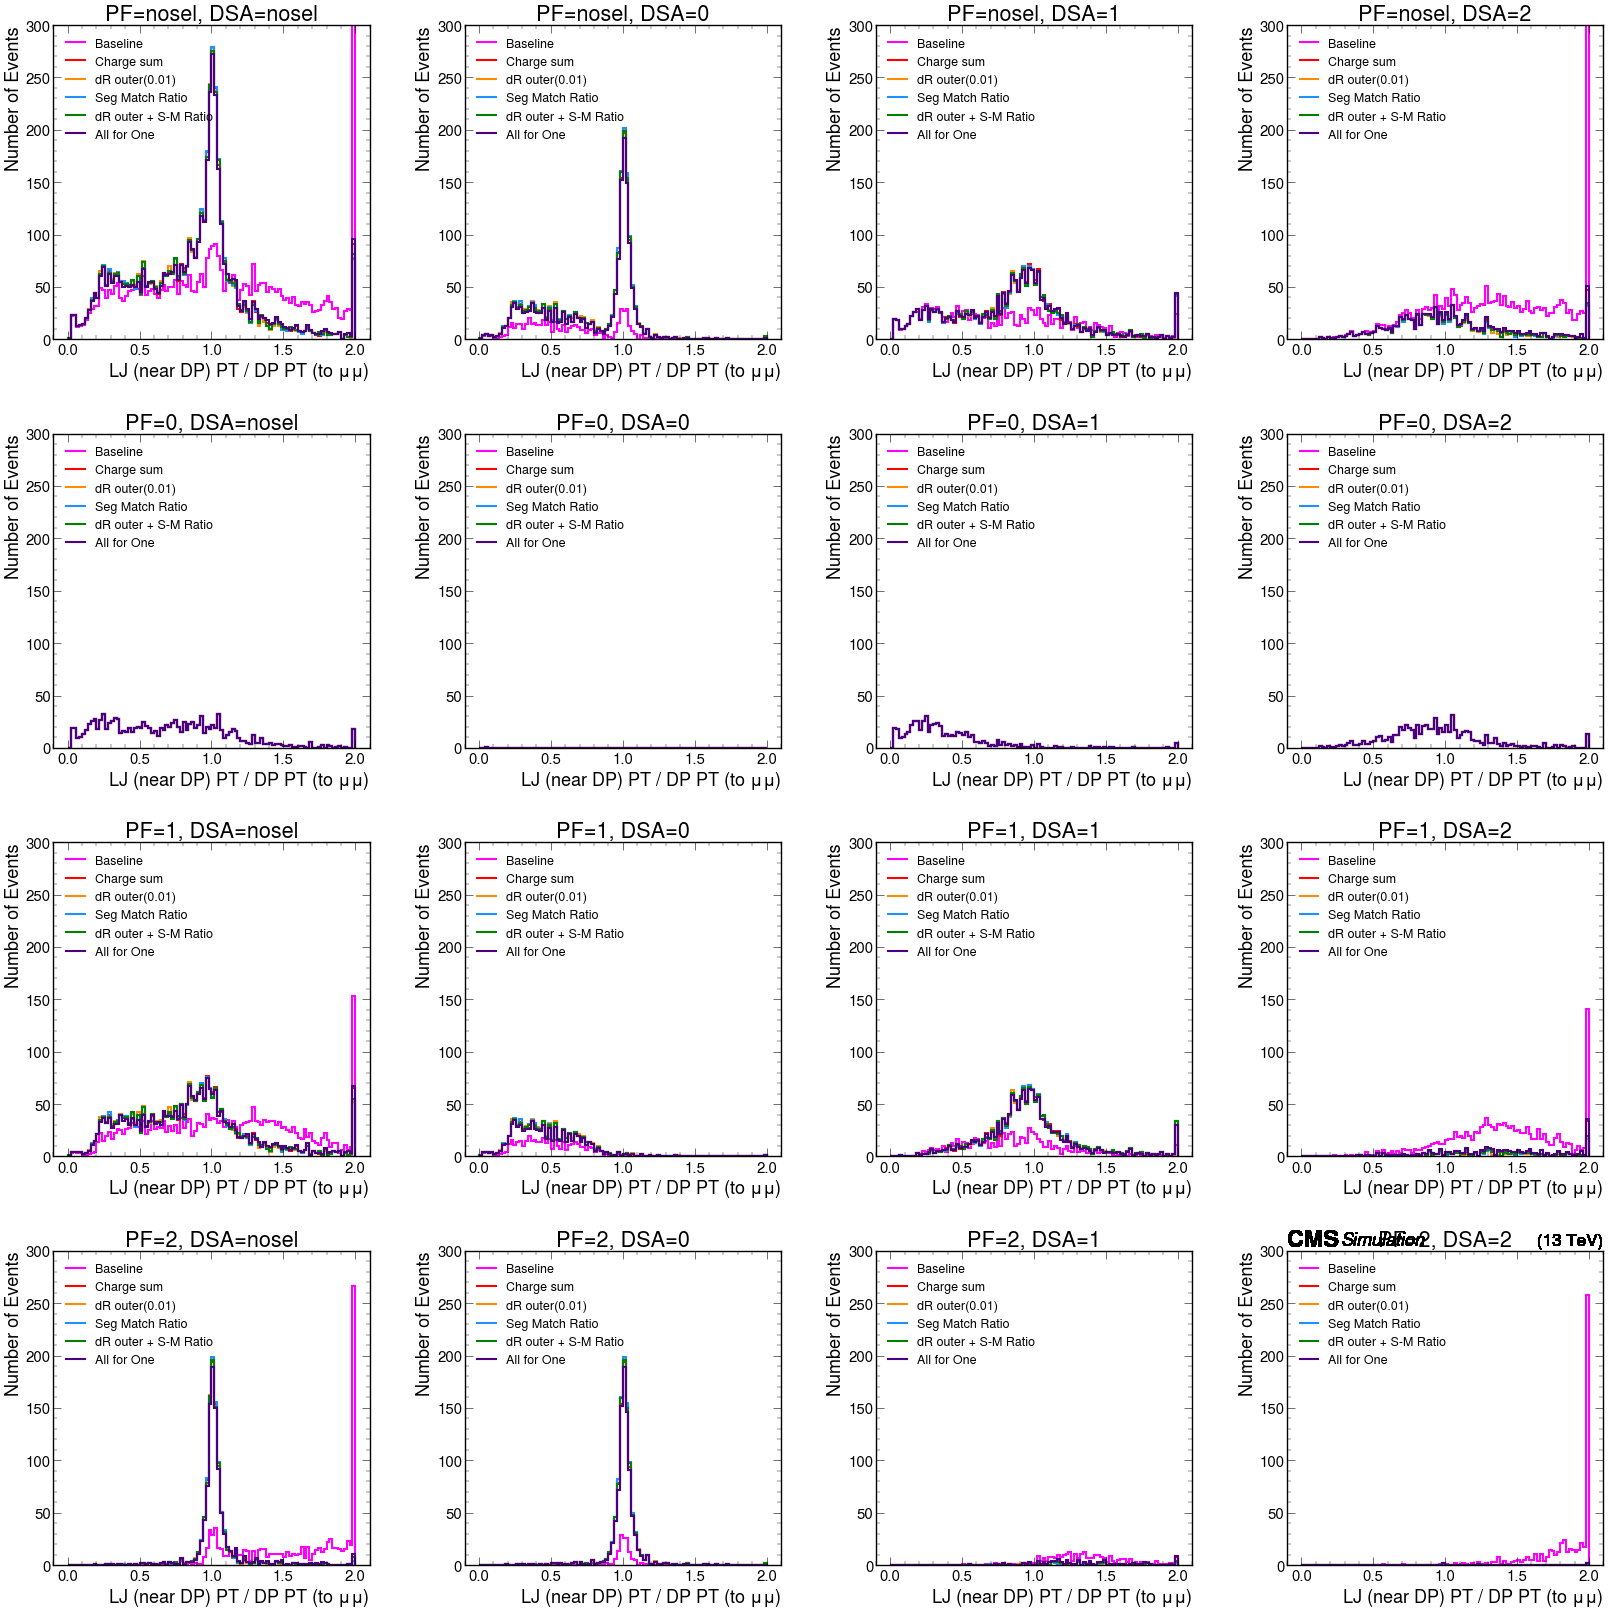

In [20]:
sample = "2Mu2E_1000GeV_0p25GeV_2p0mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_ptratio[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 300)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


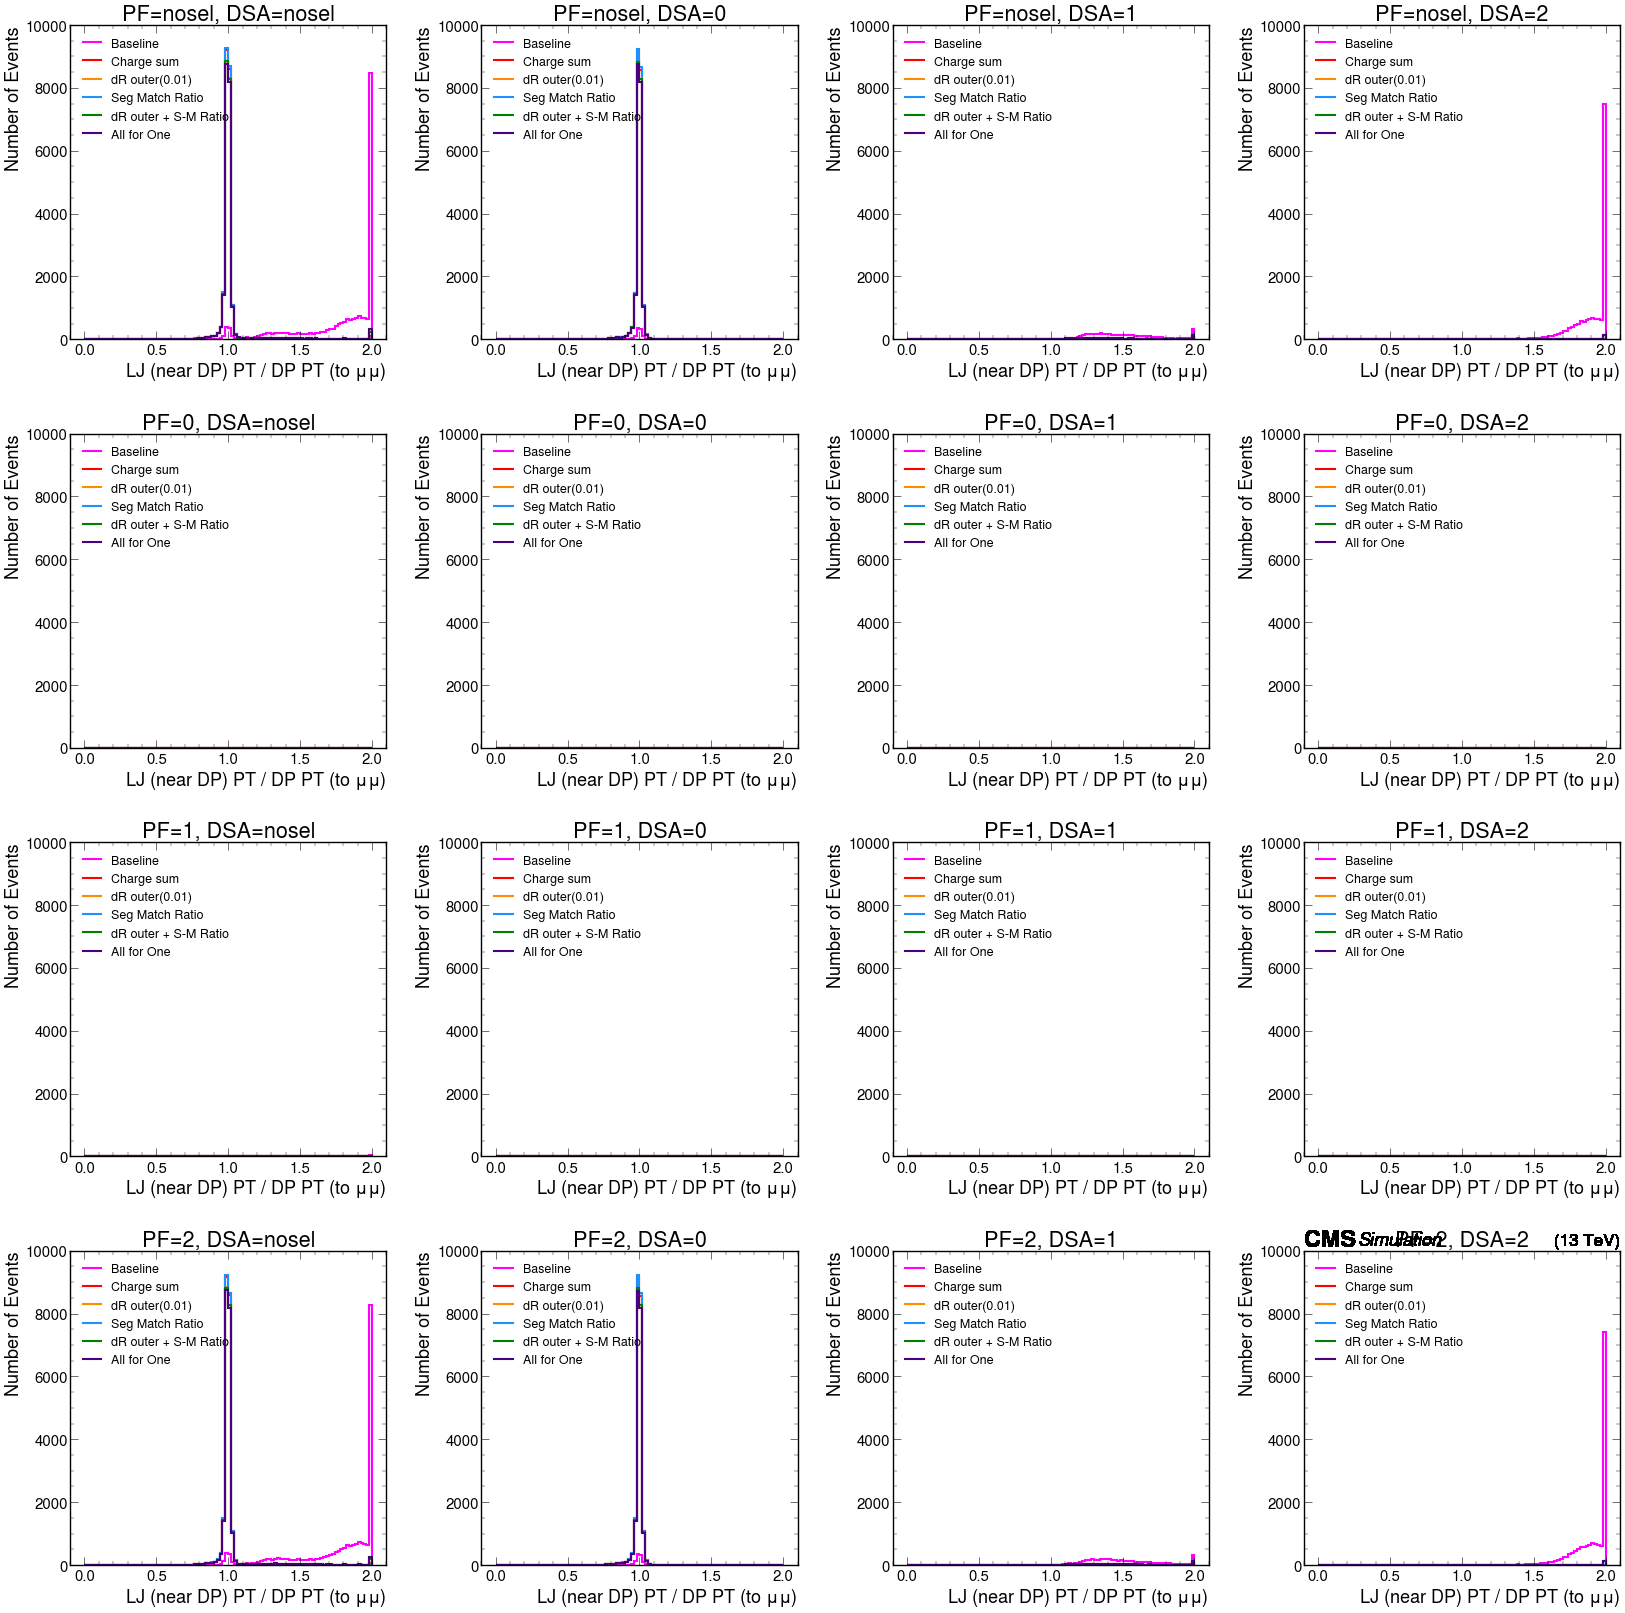

In [21]:
sample = "2Mu2E_200GeV_5p0GeV_0p2mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_ptratio[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 10000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


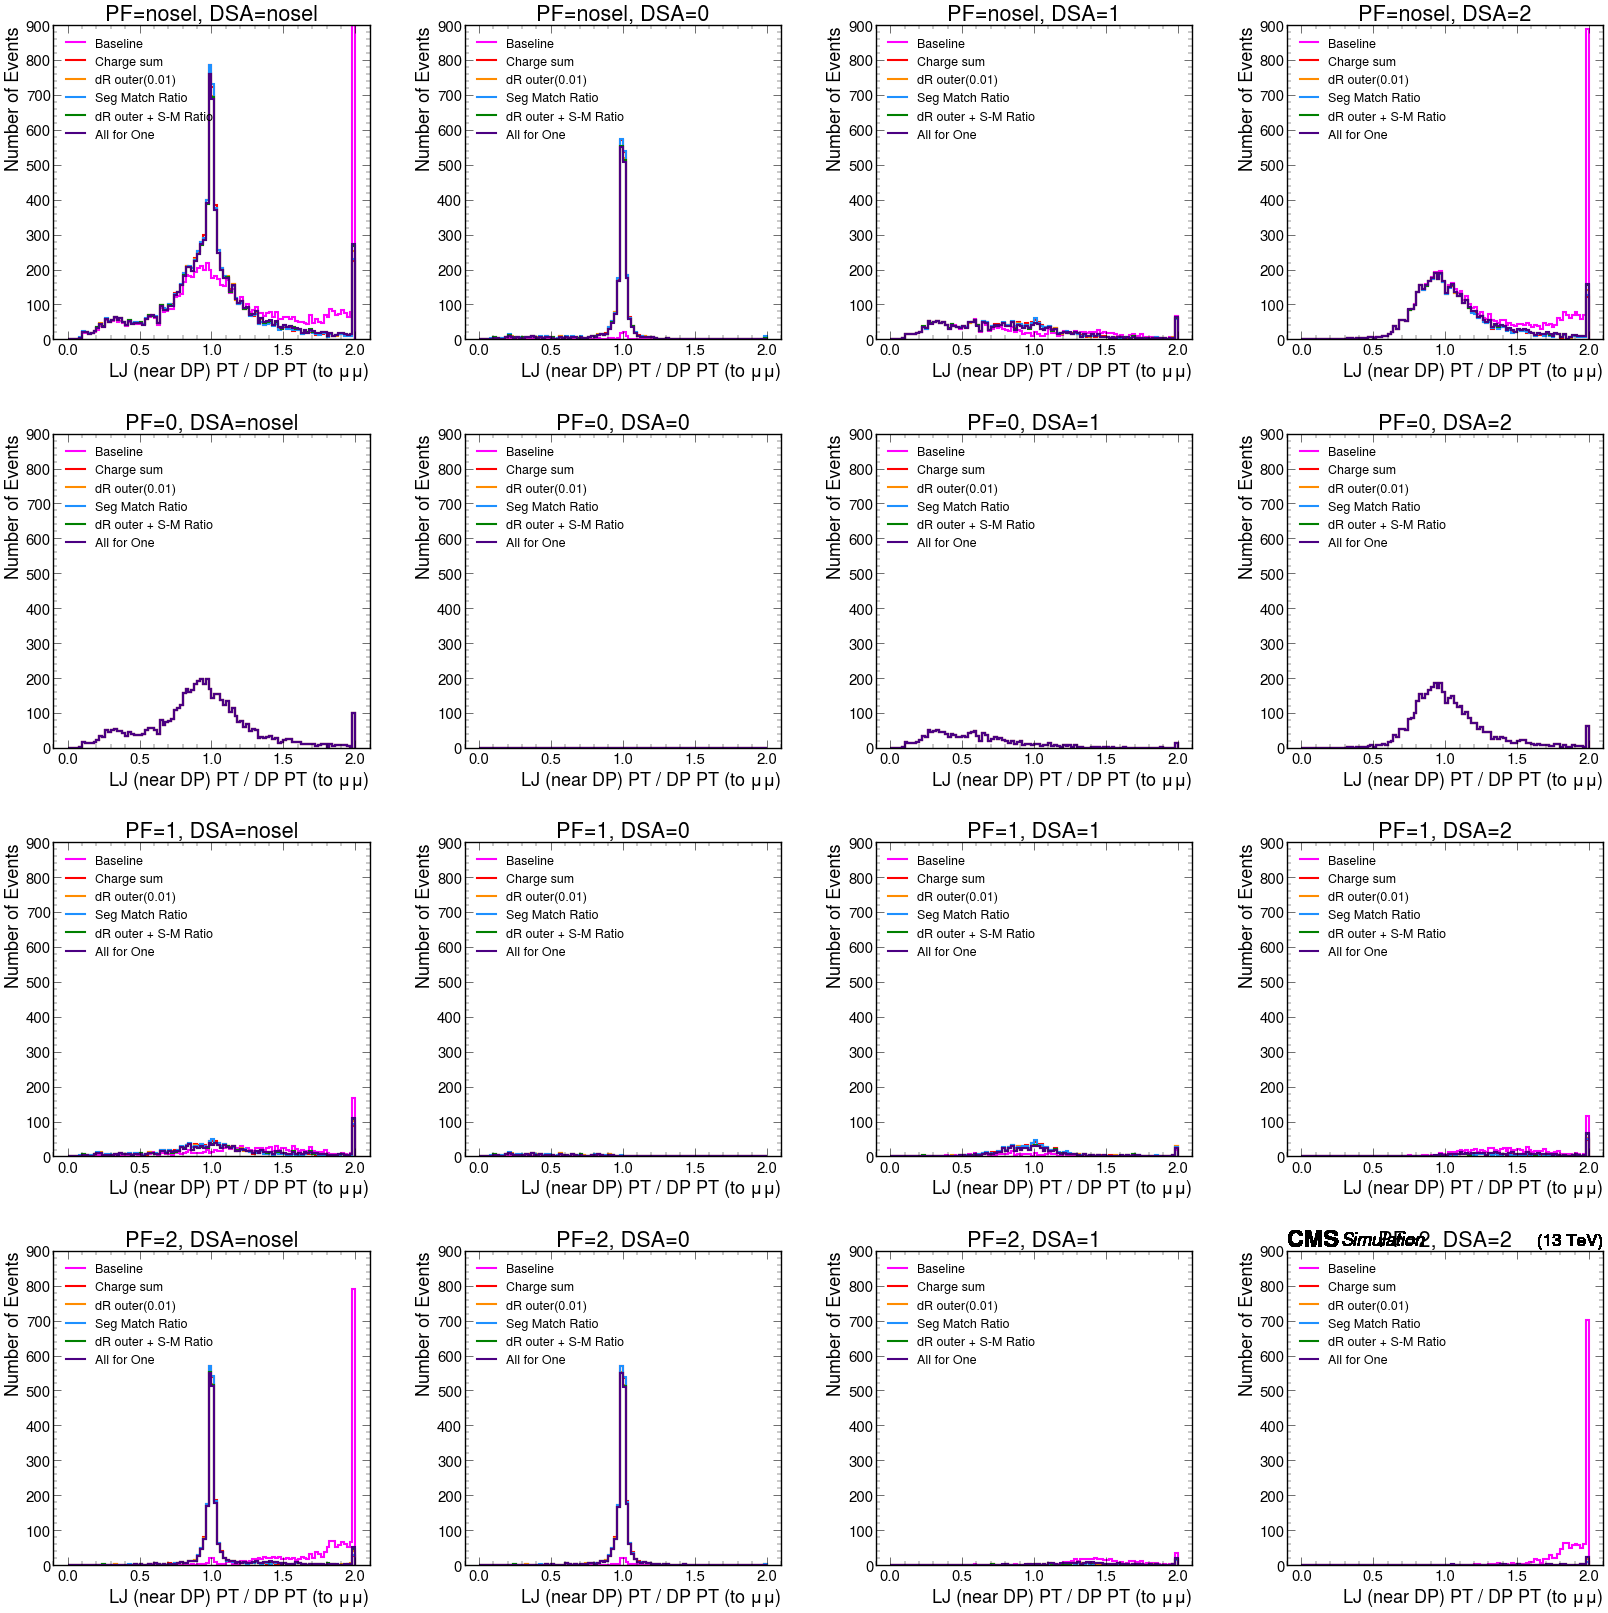

In [22]:
sample = "2Mu2E_200GeV_5p0GeV_200p0mm"
channels = ["baseNoLj_DP_matching", "baseNoLj_DP_matching_seg_veto_charge", "baseNoLj_DP_matching_seg_veto_dRouter", "baseNoLj_DP_matching_seg_veto_numseg", "baseNoLj_DP_matching_wocharge", "baseNoLj_DP_matching_all"]
legends = ["Baseline","Charge sum", "dR outer(0.01)", "Seg Match Ratio", "dR outer + S-M Ratio", "All for One"]
colors = ["fuchsia", "r", "darkorange", "dodgerblue", "g", "indigo"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_ptratio[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx], color=colors[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 900)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper left', fontsize=18)

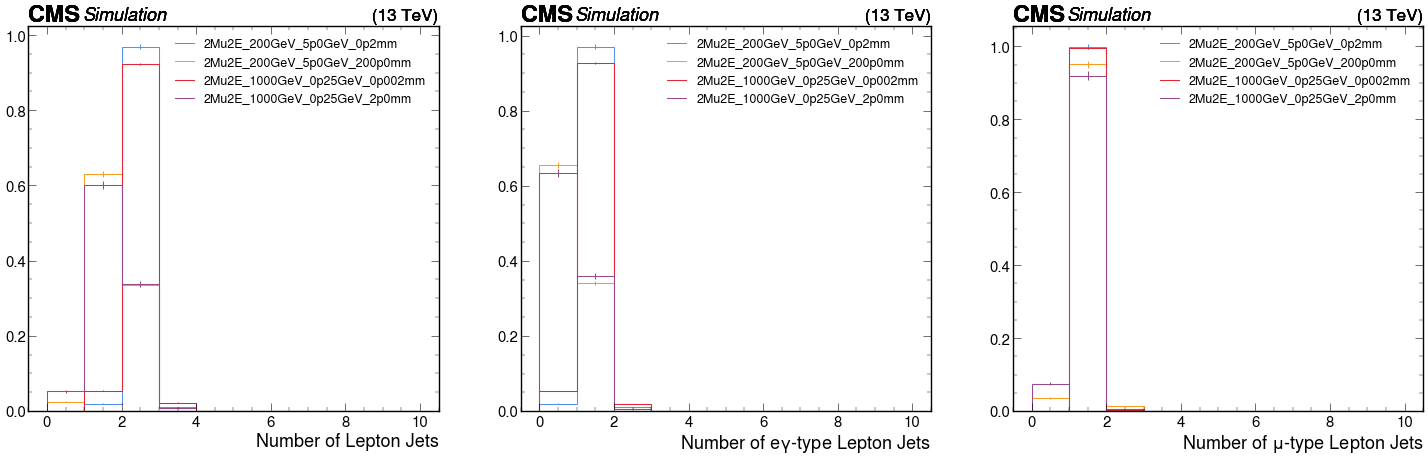

In [39]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["lj_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["egm_lj_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})

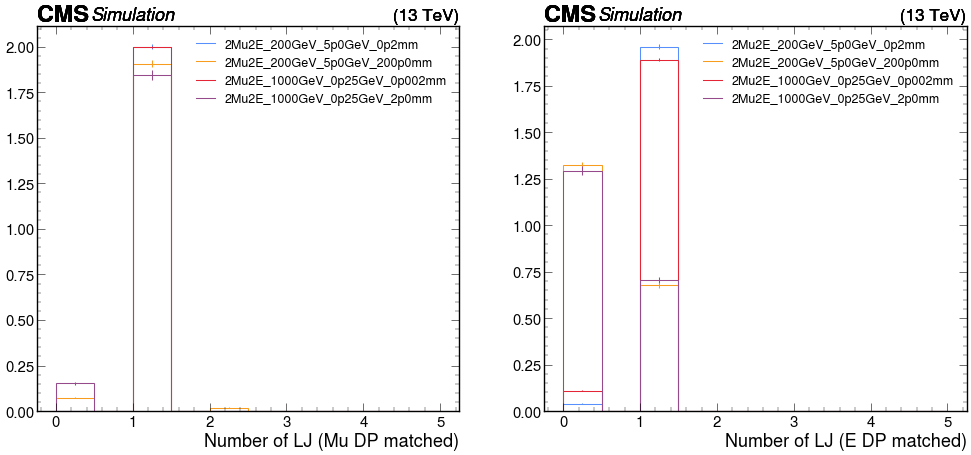

In [40]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mlj_num"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["elj_num"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})

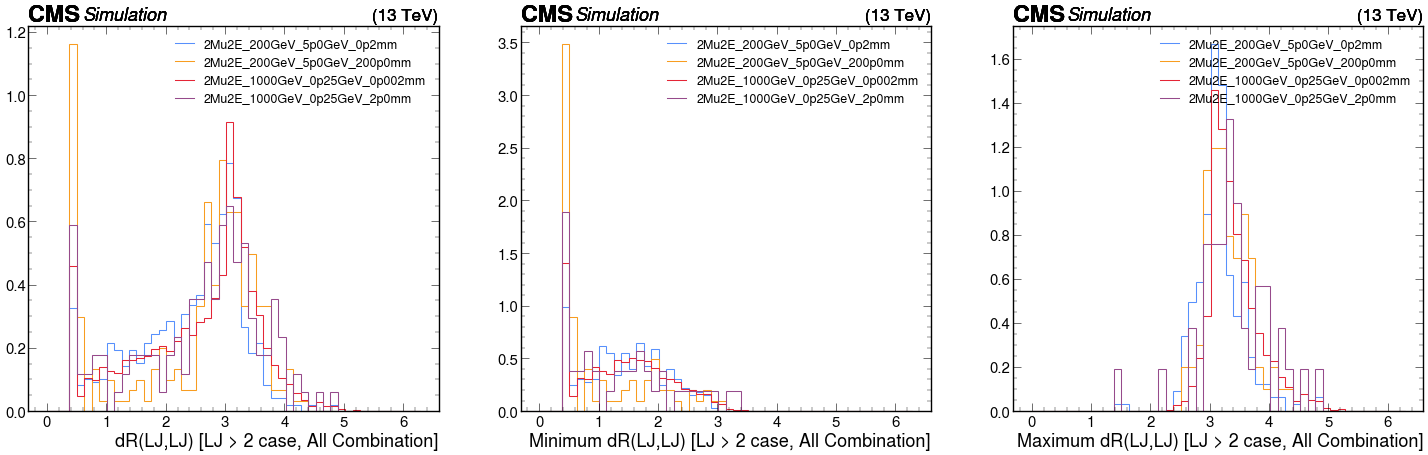

In [43]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["lj_lj_dR"][channels[0], :], density=True, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["min_lj_lj_dR"][channels[0], :], density=True, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["max_lj_lj_dR"][channels[0], :], density=True, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

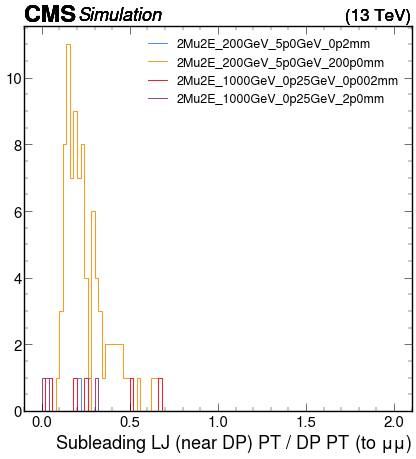

In [52]:
for sample in samples:
    utilities.plot(out[sample]["hists"]["sub_lj_dp_pt_ratio"]["baseNoLj_DP_matching", :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

In [61]:
for sample in samples:
    print(sample, ak.sum(out[sample]["hists"]["lj_dp_pt_ratio_nosel"]["baseNoLj_DP_matching", :].values()))

2Mu2E_200GeV_5p0GeV_0p2mm 14798.0
2Mu2E_200GeV_5p0GeV_200p0mm 8174.0
2Mu2E_1000GeV_0p25GeV_0p002mm 55083.0
2Mu2E_1000GeV_0p25GeV_2p0mm 4346.0


In [60]:
for sample in samples:
    print(sample, ak.sum(out[sample]["hists"]["sub_lj_dp_pt_ratio"]["baseNoLj_DP_matching", :].values()))

2Mu2E_200GeV_5p0GeV_0p2mm 2.0
2Mu2E_200GeV_5p0GeV_200p0mm 90.0
2Mu2E_1000GeV_0p25GeV_0p002mm 6.0
2Mu2E_1000GeV_0p25GeV_2p0mm 3.0


In [ ]:
    "2Mu2E_200GeV_5p0GeV_0p2mm",
    "2Mu2E_200GeV_5p0GeV_200p0mm",
    "2Mu2E_1000GeV_0p25GeV_0p002mm",
    "2Mu2E_1000GeV_0p25GeV_2p0mm",